# Demo for processing NIRSpec data from DD-2756 (PI: Pat Kelly)

In [1]:
# Environment variables for jwst pipeline
import os

for k in ['CRDS_SERVER_URL','CRDS_PATH']:
    if k not in os.environ:
        print(f"Environment variable {k} not set, `jwst` pipeline won't work")
    else:
        print(f"{k}: {os.environ[k]}")
        

CRDS_SERVER_URL: https://jwst-crds.stsci.edu
CRDS_PATH: /Users/wmb629/Astro/data/JWST/CRDS


In [2]:
# Are we on a GitHub codespace?
import os

if os.getcwd().startswith('/workspaces/msaexp'):
    import os
    os.environ['CRDS_PATH'] = os.path.join('/tmp/', 'crds_cache')

    if not os.path.exists(os.environ['CRDS_PATH']):
        ! mkdir {os.environ['CRDS_PATH']}

    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

    print('On codespace: ', os.environ['CRDS_PATH'], os.environ['CRDS_SERVER_URL'])

    workdir  = '/workspaces/msaexp/docs/examples/codespace'
    if not os.path.exists(workdir):
        ! mkdir {workdir}
    
    os.chdir(workdir)

else:
    print('Not on a codespace')


Not on a codespace


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import msaexp
from msaexp import pipeline

print(f'msaexp version = {msaexp.__version__}')

msaexp version = 0.6.11


In [4]:
os.getcwd()

'/Users/wmb629/code/python/msaexp/docs/examples'

# Query MAST for NIRSpec data

Query by program name and download `rate.fits` files with `mastquery`.  May need to set `$MAST_TOKEN` environment variable to enable the downloads from MAST.

Can optionally limit the query to specific 

 - gratings:  ``prism``, ``g140m``, ``g235m``, ``g395m``, ``g140m``, ``g235m``, ``g395m``
 - filters:  ``clear``, ``f170lp``, ``f100lp``, ``f170lp``, ``f290lp``
 - detectors: ``nrs1``, ``nrs2``
 
 

In [5]:
# Query NIRSpec data for a program name
masks = pipeline.query_program(2767, download=True, gratings=['prism'], detectors=['nrs2'])

2023-07-16 12:25:22,078 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-059 CANNOT BE CHECKED AGAINST ONLINE VERSION


In [6]:
masks['filename','program','filter','grating','detector','msametfl']

filename,program,filter,grating,detector,msametfl
str39,int64,str5,str5,str4,str25
jw02767005001_03105_00002_nrs2_s2d.fits,2767,CLEAR,PRISM,NRS2,jw02767005001_02_msa.fits
jw02767005001_03105_00003_nrs2_s2d.fits,2767,CLEAR,PRISM,NRS2,jw02767005001_02_msa.fits
jw02767005001_03105_00004_nrs2_s2d.fits,2767,CLEAR,PRISM,NRS2,jw02767005001_02_msa.fits


# Initialize pipeline

Exposures are grouped by detector and with a common `MSAMETFL` metadata file for the MSA setup.

In [6]:
import glob
files = glob.glob('jw02767*rate.fits')

groups = pipeline.exposure_groups(files=files)
print('\nFiles: ')
for g in groups:
    if '2767' not in g:
        continue
        
    print (f"{g} : {' '.join(groups[g])}")

   N  value     
====  ==========
   3  jw02767005001-02-05-clear-prism-nrs2

Files: 
jw02767005001-02-05-clear-prism-nrs2 : jw02767005001_03105_00002_nrs2_rate.fits jw02767005001_03105_00004_nrs2_rate.fits jw02767005001_03105_00003_nrs2_rate.fits


In [7]:
pipe = pipeline.NirspecPipeline(mode='jw02767005001-02-05-clear-prism-nrs2', source_ids=[11027, 2740], pad=1)

# (2023-07-16 17:26:18.431)
msaexp.NirspecPipeline: Initialize jw02767005001-02-05-clear-prism-nrs2
msaexp.NirspecPipeline: jw02767005001_03105_00002_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00003_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00004_nrs2_rate.fits
# (2023-07-16 17:26:18.672)
msaexp.utils.pad_msa_metafile: Trim source_id in jw02767005001_02_msa.fits to [2740, 11027]
msaexp.utils.pad_msa_metafile: pad = 1
msaexp.NirspecPipeline: mode=jw02767005001-02-05-clear-prism-nrs2 exp_type=NRS_MSASPEC  msametfl=src_jw02767005001_02_msa.fits


## Preprocessing pipeline

1. Run 1/f correction and identify "snowballs" on the `rate.fits` files
2. Remove "bias" (i.e., simple median) of each exposure
3. Run parts of the Level 2 JWST calibration pipeline ([calweb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2)):
  - [AssignWcs](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.assign_wcs.AssignWcsStep.html) : initialize WCS and populate slit bounding_box data
  - [Extract2dStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.extract_2d.Extract2dStep.html) : identify slits and set slit WCS
  - [FlatFieldStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.flatfield.FlatFieldStep.html#flatfieldstep) : slit-level flat field
  - [PathLossStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pathloss.PathLossStep.html) : NIRSpec path loss
  - [PhotomStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.photom.PhotomStep.html) : Photometric calibration
  
  Note that the `srctype`, `master_background`, `wavecorr` steps are not performed.  The background subtraction is done manually on the 2D slit cutouts.
  
4. Parse slit metadata
5. Save slit cutout files of the last pipeline step performed (`phot` = `PhotomStep`)

Subsequent re-initialization of the `NirspecPipeline` object and `full_pipeline` method will skip these steps and just load the saved slit cutouts.

In [8]:
# Run the pipeline to define slits, etc., but don't do extractions yet.  
if not os.path.exists(f'{pipe.mode}.slits.yaml'):
    pipe.full_pipeline(run_extractions=False, initialize_bkg=False)
else:
    print('Skip preprocessing')

# (2023-07-16 17:26:39.654)
msaexp.preprocess : set CRDS_CTX=jwst_1088.pmap
# (2023-07-16 17:26:39.655)

prep.mask_snowballs(**{'visit': {'product': 'jw02767005001-02-05-clear-prism-nrs2', 'files': ['jw02767005001_03105_00002_nrs2_rate.fits', 'jw02767005001_03105_00003_nrs2_rate.fits', 'jw02767005001_03105_00004_nrs2_rate.fits']}, 'snowball_erode': 8, 'snowball_dilate': 24, 'mask_bit': 1024, 'instruments': ['NIRSPEC'], 'max_fraction': 0.3, 'unset4': False, 'kwargs': {}})

Snowball mask: jw02767005001_03105_00002_nrs2_rate.fits  N=  9(f=0.38%)
Snowball mask: jw02767005001_03105_00003_nrs2_rate.fits  N= 15(f=0.64%)
Snowball mask: jw02767005001_03105_00004_nrs2_rate.fits  N=  9(f=1.10%)
msaexp.preprocess : jw02767005001_03105_00002_nrs2_rate.fits  bias offset =   0.000 (from MASKBIAS)
msaexp.preprocess : jw02767005001_03105_00002_nrs2_rate.fits    rms scale =    1.39 (from SCLREADN)


2023-07-16 12:26:41,198 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


msaexp.preprocess : jw02767005001_03105_00003_nrs2_rate.fits  bias offset =  -0.003 (from MASKBIAS)
msaexp.preprocess : jw02767005001_03105_00003_nrs2_rate.fits    rms scale =    1.41 (from SCLREADN)
msaexp.preprocess : jw02767005001_03105_00004_nrs2_rate.fits  bias offset =  -0.000 (from MASKBIAS)
msaexp.preprocess : jw02767005001_03105_00004_nrs2_rate.fits    rms scale =    1.41 (from SCLREADN)


2023-07-16 12:26:43,269 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2023-07-16 12:26:43,352 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from jw02767005001_03105_00002_nrs2_rate.fits>,).
2023-07-16 12:26:43,354 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2023-07-16 12:26:43,463 - CRDS - INFO -  Fetching  /Users/wmb629/Astro/data/JWST/CRDS/references/jwst/nirspec/jwst_nirspec_camera_0008.asdf    6.5 K bytes  (1 / 1 files) (0 / 6.5 K bytes)
2023-07-16 12:26:43,743 - CRDS -

2023-07-16 12:26:50,633 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs
2023-07-16 12:26:50,654 - stpipe.AssignWcsStep - INFO - Results used CRDS context: jwst_1100.pmap
2023-07-16 12:26:50,655 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done
2023-07-16 12:26:51,008 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2023-07-16 12:26:51,124 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from jw02767005001_03105_00004_nrs2_rate.fits>,).
2023-07-16 12:26:51,126 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y

# (2023-07-16 17:26:53.062)
msaexp.jwst.MSAFlagOpenStep: jw02767005001_03105_00002_nrs2_rate.fits


2023-07-16 12:26:54,466 - stpipe.MSAFlagOpenStep - INFO - Using reference file /Users/wmb629/Astro/data/JWST/CRDS/references/jwst/nirspec/jwst_nirspec_msaoper_0005.json
2023-07-16 12:26:54,468 - stpipe.JwstStep - INFO - JwstStep instance created.
2023-07-16 12:26:54,667 - stpipe.MSAFlagOpenStep - INFO - gwa_ytilt is 0.03236998999999953 deg
2023-07-16 12:26:54,668 - stpipe.MSAFlagOpenStep - INFO - gwa_xtilt is 0.3355620500000074 deg
2023-07-16 12:26:54,669 - stpipe.MSAFlagOpenStep - INFO - theta_y correction: 0.005024324185132704 deg
2023-07-16 12:26:54,670 - stpipe.MSAFlagOpenStep - INFO - theta_x correction: 0.0003358805885163976 deg
2023-07-16 12:26:54,693 - stpipe.MSAFlagOpenStep - INFO - SPORDER= 0, wrange=[6e-07, 5.3e-06]
2023-07-16 12:26:54,885 - stpipe.MSAFlagOpenStep - INFO - There are 6 open slits in quadrant 1
2023-07-16 12:26:54,940 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 2
2023-07-16 12:26:54,964 - stpipe.MSAFlagOpenStep - INFO - There are 12 op

# (2023-07-16 17:27:12.640)
msaexp.jwst.MSAFlagOpenStep: jw02767005001_03105_00003_nrs2_rate.fits


2023-07-16 12:27:12,939 - stpipe.MSAFlagOpenStep - INFO - Using reference file /Users/wmb629/Astro/data/JWST/CRDS/references/jwst/nirspec/jwst_nirspec_msaoper_0005.json
2023-07-16 12:27:12,941 - stpipe.JwstStep - INFO - JwstStep instance created.
2023-07-16 12:27:13,149 - stpipe.MSAFlagOpenStep - INFO - gwa_ytilt is 0.03236998999999953 deg
2023-07-16 12:27:13,149 - stpipe.MSAFlagOpenStep - INFO - gwa_xtilt is 0.3355620500000074 deg
2023-07-16 12:27:13,150 - stpipe.MSAFlagOpenStep - INFO - theta_y correction: 0.005024324185132704 deg
2023-07-16 12:27:13,152 - stpipe.MSAFlagOpenStep - INFO - theta_x correction: 0.0003358805885163976 deg
2023-07-16 12:27:13,177 - stpipe.MSAFlagOpenStep - INFO - SPORDER= 0, wrange=[6e-07, 5.3e-06]
2023-07-16 12:27:13,384 - stpipe.MSAFlagOpenStep - INFO - There are 6 open slits in quadrant 1
2023-07-16 12:27:13,438 - stpipe.MSAFlagOpenStep - INFO - There are 3 open slits in quadrant 2
2023-07-16 12:27:13,468 - stpipe.MSAFlagOpenStep - INFO - There are 12 op

# (2023-07-16 17:27:31.890)
msaexp.jwst.MSAFlagOpenStep: jw02767005001_03105_00004_nrs2_rate.fits


2023-07-16 12:27:32,151 - stpipe.MSAFlagOpenStep - INFO - Step MSAFlagOpenStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-07-16 12:27:32,175 - stpipe.MSAFlagOpenStep - INFO - Using reference file /Users/wmb629/Astro/data/JWST/CRDS/references/jwst/nirspec/jwst_nirspec_msaoper_0005.json
2023-07-16 12:27:32,176 - stpipe.JwstStep - INFO - JwstStep instance created.
2023-07-16 12:27:32,394 - stpipe.MSAFlagOpenStep - INFO - gwa_ytilt is 0.03236998999999953 deg
2023-07-16 12:27:32,395 - stpipe.MSAFlagOpenStep - INFO - gwa_xtilt is 0.3355620500000074 deg
2023-07-16 12:27:32,396 - stpipe.MSAFlagOpenStep - INFO - theta_y correction: 0.005024324185132704 deg
2023-07-16 12:27:32,398 - stpipe.MSAFlagOpenStep - INFO - theta_x correction: 0.0003358805885163976 deg
2023-07-16

# (2023-07-16 17:27:51.755)
msaexp.jwst.Extract2dStep: jw02767005001_03105_00002_nrs2_rate.fits


2023-07-16 12:27:52,084 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'extract_orders': None, 'grism_objects': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'wfss_mmag_extract': None, 'wfss_nbright': 1000}
2023-07-16 12:27:52,112 - stpipe.Extract2dStep - INFO - EXP_TYPE is NRS_MSASPEC
2023-07-16 12:27:52,405 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 128
2023-07-16 12:27:52,405 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 121 542
2023-07-16 12:27:52,406 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 271 303
2023-07-16 12:27:52,766 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2023-07-16 12:27:52,782 - stpipe.Extract2dStep - 

# (2023-07-16 17:27:53.497)
msaexp.jwst.Extract2dStep: jw02767005001_03105_00003_nrs2_rate.fits


2023-07-16 12:27:53,928 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 128
2023-07-16 12:27:53,929 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 121 542
2023-07-16 12:27:53,930 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 271 303
2023-07-16 12:27:54,185 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2023-07-16 12:27:54,196 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.419809617 0.101397931 322.420227808 0.101999254 322.420183402 0.102030462 322.419765205 0.101429146
2023-07-16 12:27:54,199 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.419809617 0.101397931 322.420227808 0.101999254 322.420183402 0.102030462 322.419765205 0.101429146
2023-07-16 12:27:54,391 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 109
2023-07-16 12:27:54,391 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 336 757
2023-07-16 12:27:54,392 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 517 551

# (2023-07-16 17:27:54.799)
msaexp.jwst.Extract2dStep: jw02767005001_03105_00004_nrs2_rate.fits


2023-07-16 12:27:55,219 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 128
2023-07-16 12:27:55,219 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 121 542
2023-07-16 12:27:55,220 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 271 303
2023-07-16 12:27:55,502 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2023-07-16 12:27:55,515 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  322.419641135 0.101157154 322.420059325 0.101758476 322.420014919 0.101789685 322.419596723 0.101188368
2023-07-16 12:27:55,517 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  322.419641135 0.101157154 322.420059325 0.101758476 322.420014919 0.101789685 322.419596723 0.101188368
2023-07-16 12:27:55,718 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 109
2023-07-16 12:27:55,719 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 336 757
2023-07-16 12:27:55,719 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 517 551

# (2023-07-16 17:27:56.157)
msaexp.jwst.FlatFieldStep: jw02767005001_03105_00002_nrs2_rate.fits


2023-07-16 12:27:56,579 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2023-07-16 12:27:56,726 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<MultiSlitModel from jw02767005001_03105_00002_nrs2_rate.fits>,).
2023-07-16 12:27:56,728 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2023-07-16 12:28:00,152 - stpipe.FlatFieldStep - INFO - Working on slit 128
2023-07-16 12:28:03,282 - stpipe.FlatFieldStep - INFO - Working on slit 109
2023-07-16 12:28:07,478 - stpipe.FlatFieldStep - INFO - Results used CRDS context: jwst_1100.pmap
2023-07-16 12:28:07,478 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done


# (2023-07-16 17:28:07.480)
msaexp.jwst.FlatFieldStep: jw02767005001_03105_00003_nrs2_rate.fits


2023-07-16 12:28:09,869 - stpipe.FlatFieldStep - INFO - Working on slit 128
2023-07-16 12:28:13,554 - stpipe.FlatFieldStep - INFO - Working on slit 109
2023-07-16 12:28:17,524 - stpipe.FlatFieldStep - INFO - Results used CRDS context: jwst_1100.pmap
2023-07-16 12:28:17,525 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done
2023-07-16 12:28:17,550 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2023-07-16 12:28:17,740 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<MultiSlitModel from jw02767005001_03105_00004_nrs2_rate.fits>,).


# (2023-07-16 17:28:17.526)
msaexp.jwst.FlatFieldStep: jw02767005001_03105_00004_nrs2_rate.fits


2023-07-16 12:28:17,742 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2023-07-16 12:28:19,558 - stpipe.FlatFieldStep - INFO - Working on slit 128
2023-07-16 12:28:23,049 - stpipe.FlatFieldStep - INFO - Working on slit 109
2023-07-16 12:28:26,943 - stpipe.FlatFieldStep - INFO - Results used CRDS context: jwst_1100.pmap
2023-07-16 12:28:26,943 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done
2023-07-16 12:28:26,945 - stpipe.PathLossStep - INFO - PathLossStep instance created.
2023-07-16 12:28:26,967 - stpipe.PathLossStep - INFO - PathLossStep instance created.
2023-07-16 12:28:27,166 - stpipe.PathLossStep - INFO - Step PathLossStep run

# (2023-07-16 17:28:26.947)
msaexp.jwst.PathLossStep: jw02767005001_03105_00002_nrs2_rate.fits


2023-07-16 12:28:27,168 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2023-07-16 12:28:27,200 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /Users/wmb629/Astro/data/JWST/CRDS/references/jwst/nirspec/jwst_nirspec_pathloss_0002.fits
2023-07-16 12:28:27,298 - stpipe.PathLossStep - INFO - Input exposure type is NRS_MSASPEC
2023-07-16 12:28:27,858 - stpipe.PathLossStep - INFO - Working on slit 0
2023-07-16 12:28:27,859 - stpipe.PathLossStep - WARNING - Cannot find matching pathloss model for slit with5 shutters
2023-07-16 12:28:27,860 - stpipe.PathLossStep - WARNING - No correction provided for slit 0. Skipping
2023-07-16 12:28:27,860 - stpipe.PathLossStep - INFO - Workin

# (2023-07-16 17:28:27.900)
msaexp.jwst.PathLossStep: jw02767005001_03105_00003_nrs2_rate.fits


2023-07-16 12:28:28,132 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /Users/wmb629/Astro/data/JWST/CRDS/references/jwst/nirspec/jwst_nirspec_pathloss_0002.fits
2023-07-16 12:28:28,236 - stpipe.PathLossStep - INFO - Input exposure type is NRS_MSASPEC
2023-07-16 12:28:28,825 - stpipe.PathLossStep - INFO - Working on slit 0
2023-07-16 12:28:28,825 - stpipe.PathLossStep - WARNING - Cannot find matching pathloss model for slit with5 shutters
2023-07-16 12:28:28,826 - stpipe.PathLossStep - WARNING - No correction provided for slit 0. Skipping
2023-07-16 12:28:28,827 - stpipe.PathLossStep - INFO - Working on slit 1
2023-07-16 12:28:28,828 - stpipe.PathLossStep - WARNING - Cannot find matching pathloss model for slit with5 shutters
2023-07-16 12:28:28,829 - stpipe.PathLossStep - WARNING - No correction provided for slit 1. Skipping
2023-07-16 12:28:28,838 - stpipe.PathLossStep - INFO - Results used CRDS context: jwst_1100.pmap
2023-07-16 12:28:28,839 - stpipe.PathLossStep - INF

# (2023-07-16 17:28:28.840)
msaexp.jwst.PathLossStep: jw02767005001_03105_00004_nrs2_rate.fits


2023-07-16 12:28:29,077 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /Users/wmb629/Astro/data/JWST/CRDS/references/jwst/nirspec/jwst_nirspec_pathloss_0002.fits
2023-07-16 12:28:29,179 - stpipe.PathLossStep - INFO - Input exposure type is NRS_MSASPEC
2023-07-16 12:28:29,765 - stpipe.PathLossStep - INFO - Working on slit 0
2023-07-16 12:28:29,765 - stpipe.PathLossStep - WARNING - Cannot find matching pathloss model for slit with5 shutters
2023-07-16 12:28:29,766 - stpipe.PathLossStep - WARNING - No correction provided for slit 0. Skipping
2023-07-16 12:28:29,766 - stpipe.PathLossStep - INFO - Working on slit 1
2023-07-16 12:28:29,767 - stpipe.PathLossStep - WARNING - Cannot find matching pathloss model for slit with5 shutters
2023-07-16 12:28:29,768 - stpipe.PathLossStep - WARNING - No correction provided for slit 1. Skipping
2023-07-16 12:28:29,778 - stpipe.PathLossStep - INFO - Results used CRDS context: jwst_1100.pmap
2023-07-16 12:28:29,778 - stpipe.PathLossStep - INF

# (2023-07-16 17:28:29.786)
msaexp.jwst.BarShadowStep: jw02767005001_03105_00002_nrs2_rate.fits


2023-07-16 12:28:30,000 - stpipe.BarShadowStep - INFO - Step BarShadowStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2023-07-16 12:28:30,032 - stpipe.BarShadowStep - INFO - Using BARSHADOW reference file /Users/wmb629/Astro/data/JWST/CRDS/references/jwst/nirspec/jwst_nirspec_barshadow_0001.fits
2023-07-16 12:28:30,697 - stpipe.BarShadowStep - INFO - Working on slitlet 128
2023-07-16 12:28:30,716 - stpipe.BarShadowStep - INFO - SRCTYPE not set for slitlet 128; assuming EXTENDED
2023-07-16 12:28:30,840 - stpipe.BarShadowStep - INFO - Working on slitlet 109
2023-07-16 12:28:30,858 - stpipe.BarShadowStep - INFO - SRCTYPE not set for slitlet 109; assuming EXTENDED
2023-07-16 12:28:31,003 - stpipe.BarShadowStep - INFO - Results use

# (2023-07-16 17:28:31.006)
msaexp.jwst.BarShadowStep: jw02767005001_03105_00003_nrs2_rate.fits


2023-07-16 12:28:31,234 - stpipe.BarShadowStep - INFO - Step BarShadowStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2023-07-16 12:28:31,269 - stpipe.BarShadowStep - INFO - Using BARSHADOW reference file /Users/wmb629/Astro/data/JWST/CRDS/references/jwst/nirspec/jwst_nirspec_barshadow_0001.fits
2023-07-16 12:28:31,999 - stpipe.BarShadowStep - INFO - Working on slitlet 128
2023-07-16 12:28:32,020 - stpipe.BarShadowStep - INFO - SRCTYPE not set for slitlet 128; assuming EXTENDED
2023-07-16 12:28:32,158 - stpipe.BarShadowStep - INFO - Working on slitlet 109
2023-07-16 12:28:32,179 - stpipe.BarShadowStep - INFO - SRCTYPE not set for slitlet 109; assuming EXTENDED
2023-07-16 12:28:32,324 - stpipe.BarShadowStep - INFO - Results use

# (2023-07-16 17:28:32.326)
msaexp.jwst.BarShadowStep: jw02767005001_03105_00004_nrs2_rate.fits


2023-07-16 12:28:32,555 - stpipe.BarShadowStep - INFO - Step BarShadowStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2023-07-16 12:28:32,591 - stpipe.BarShadowStep - INFO - Using BARSHADOW reference file /Users/wmb629/Astro/data/JWST/CRDS/references/jwst/nirspec/jwst_nirspec_barshadow_0001.fits
2023-07-16 12:28:33,322 - stpipe.BarShadowStep - INFO - Working on slitlet 128
2023-07-16 12:28:33,344 - stpipe.BarShadowStep - INFO - SRCTYPE not set for slitlet 128; assuming EXTENDED
2023-07-16 12:28:33,491 - stpipe.BarShadowStep - INFO - Working on slitlet 109
2023-07-16 12:28:33,512 - stpipe.BarShadowStep - INFO - SRCTYPE not set for slitlet 109; assuming EXTENDED
2023-07-16 12:28:33,662 - stpipe.BarShadowStep - INFO - Results use

# (2023-07-16 17:28:33.666)
msaexp.jwst.PhotomStep: jw02767005001_03105_00002_nrs2_rate.fits


2023-07-16 12:28:33,913 - stpipe.PhotomStep - INFO - Step PhotomStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2023-07-16 12:28:33,968 - stpipe.PhotomStep - INFO - Using photom reference file: /Users/wmb629/Astro/data/JWST/CRDS/references/jwst/nirspec/jwst_nirspec_photom_0015.fits
2023-07-16 12:28:33,969 - stpipe.PhotomStep - INFO - Using area reference file: /Users/wmb629/Astro/data/JWST/CRDS/references/jwst/nirspec/jwst_nirspec_area_0033.fits
2023-07-16 12:28:34,601 - stpipe.PhotomStep - INFO - Using instrument: NIRSPEC
2023-07-16 12:28:34,602 - stpipe.PhotomStep - INFO -  detector: NRS2
2023-07-16 12:28:34,602 - stpipe.PhotomStep - INFO -  exp_type: NRS_MSASPEC
2023-07-16 12:28:34,603 - stpipe.PhotomStep - INFO -  filter: 

# (2023-07-16 17:28:34.770)
msaexp.jwst.PhotomStep: jw02767005001_03105_00003_nrs2_rate.fits


2023-07-16 12:28:35,014 - stpipe.PhotomStep - INFO - Step PhotomStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2023-07-16 12:28:35,071 - stpipe.PhotomStep - INFO - Using photom reference file: /Users/wmb629/Astro/data/JWST/CRDS/references/jwst/nirspec/jwst_nirspec_photom_0015.fits
2023-07-16 12:28:35,072 - stpipe.PhotomStep - INFO - Using area reference file: /Users/wmb629/Astro/data/JWST/CRDS/references/jwst/nirspec/jwst_nirspec_area_0033.fits
2023-07-16 12:28:35,758 - stpipe.PhotomStep - INFO - Using instrument: NIRSPEC
2023-07-16 12:28:35,759 - stpipe.PhotomStep - INFO -  detector: NRS2
2023-07-16 12:28:35,759 - stpipe.PhotomStep - INFO -  exp_type: NRS_MSASPEC
2023-07-16 12:28:35,760 - stpipe.PhotomStep - INFO -  filter: 

# (2023-07-16 17:28:35.931)
msaexp.jwst.PhotomStep: jw02767005001_03105_00004_nrs2_rate.fits


2023-07-16 12:28:36,200 - stpipe.PhotomStep - INFO - Step PhotomStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2023-07-16 12:28:36,274 - stpipe.PhotomStep - INFO - Using photom reference file: /Users/wmb629/Astro/data/JWST/CRDS/references/jwst/nirspec/jwst_nirspec_photom_0015.fits
2023-07-16 12:28:36,275 - stpipe.PhotomStep - INFO - Using area reference file: /Users/wmb629/Astro/data/JWST/CRDS/references/jwst/nirspec/jwst_nirspec_area_0033.fits
2023-07-16 12:28:37,288 - stpipe.PhotomStep - INFO - Using instrument: NIRSPEC
2023-07-16 12:28:37,289 - stpipe.PhotomStep - INFO -  detector: NRS2
2023-07-16 12:28:37,289 - stpipe.PhotomStep - INFO -  exp_type: NRS_MSASPEC
2023-07-16 12:28:37,290 - stpipe.PhotomStep - INFO -  filter: 

# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02767005001-02-05-clear-prism-nrs2
   0   128    2767_2740  322.419896 0.101574
   1   109   2767_11027  322.421553 0.091687
# (2023-07-16 17:28:37.514)
msaexp.get_slit_traces: Run
msaexp.get_slit_traces: Trace set at index 0 for 2767_2740
msaexp.get_slit_traces: Trace set at index 0 for 2767_11027
jw02767005001-02-05-clear-prism-nrs2.slits.yaml
msaexp.save_slit_data: jw02767005001_03105_00002_nrs2_phot.128.2767_2740.fits 
msaexp.save_slit_data: jw02767005001_03105_00002_nrs2_phot.109.2767_11027.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs2_phot.128.2767_2740.fits 
msaexp.save_slit_data: jw02767005001_03105_00003_nrs2_phot.109.2767_11027.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs2_phot.128.2767_2740.fits 
msaexp.save_slit_data: jw02767005001_03105_00004_nrs2_phot.109.2767_11027.fits 


In [9]:
import glob
files = glob.glob(f'{pipe.mode}*')
files.sort()
for f in files:
    print(f)

jw02767005001-02-05-clear-prism-nrs2.log.txt
jw02767005001-02-05-clear-prism-nrs2.reg
jw02767005001-02-05-clear-prism-nrs2.slits.reg
jw02767005001-02-05-clear-prism-nrs2.slits.yaml


In [12]:
# Parse slit polygons
# try to use the slitlet WCS to generate a polygon in sky coordinates of the slit locations
if not os.path.exists('jw02767005001-02-05-clear-prism-nrs2.slits.reg'):
   pipe.get_slit_polygons()

## Pipeline products

In [10]:
print('Pipeline entries: ', list(pipe.pipe.keys()))
print('Last step: ', pipe.last_step)

Pipeline entries:  ['phot']
Last step:  phot


# Reinitialize with limited set of targets

In [14]:
targets = ['2767_11027', # z=9.5 galaxy from Williams et al.
           '2767_2740', # z=1.14
          ]

pipe = pipeline.NirspecPipeline(mode='jw02767005001-02-05-clear-prism-nrs2')
pipe.full_pipeline(run_extractions=False, targets=targets)

# (2023-06-06 01:59:40.999)
msaexp.NirspecPipeline: Initialize jw02767005001-02-05-clear-prism-nrs2
msaexp.NirspecPipeline: jw02767005001_03105_00002_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00003_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00004_nrs2_rate.fits
msaexp.NirspecPipeline: mode=jw02767005001-02-05-clear-prism-nrs2 exp_type=NRS_MSASPEC  msametfl=jw02767005001_02_msa.fits
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.109.2767_11027.fits 2767_11027
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.128.2767_2740.fits 2767_2740
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.109.2767_11027.fits 2767_11027
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.128.2767_2740.fits 2767_2740
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.109.2767_11027.fits 2767_11027
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.128.2767_2740.fits 2767_2740
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02767005001-02

## Slitlet metadata

In [15]:
pipe.targets

['2767_11027', '2767_2740']

# Extract spectra

yoffset : offset in pixels relative to where the slit WCS thinks the target coordinates should be

prof_sigma : gaussian profile sigma width

skip : list of indices to exclude from the combination to avoid bad pixels, misalignment, etc.

Failed to `import dust_attenuation`
Install my fork with $ pip install git+https://github.com/gbrammer/dust_attenuation.git


2023-06-05 21:15:25,628 - stpipe - WARNING - /Users/wmb629/opt/anaconda3/envs/jwst_pipe/lib/python3.11/site-packages/msaexp/pipeline.py:1488: RuntimeWarning: All-NaN slice encountered
2023-06-05 21:15:25,629 - stpipe - WARNING -   pscl = np.nanmax(_running[1])
2023-06-05 21:15:25,629 - stpipe - WARNING - 


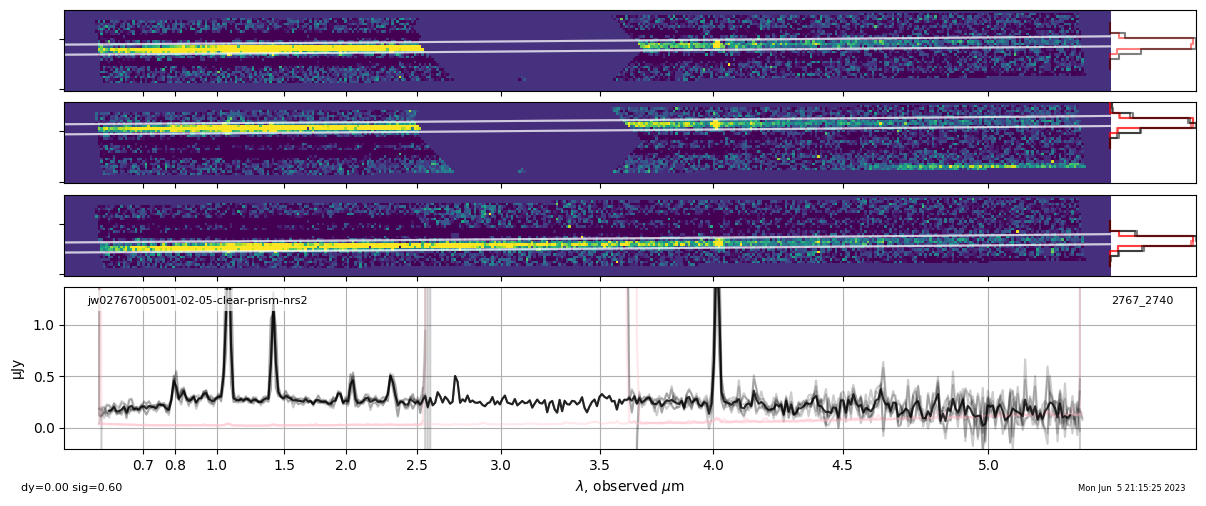

In [16]:
key = '2767_11027' # z=9.5 galaxy from Williams et al.
key = '2767_2740' # z=1.14 with lines

_ = pipe.extract_spectrum(key, skip=[], yoffset=0, prof_sigma=0.6, trace_sign=-1, fit_profile_params=None)

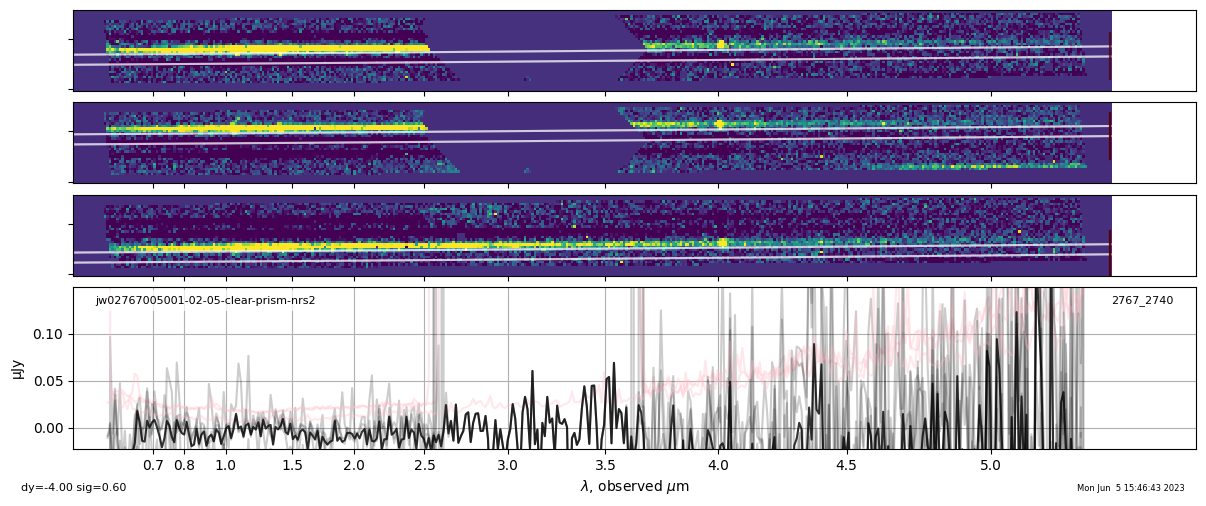

In [40]:
# Shift the extraction along the slit (bad here)
_ = pipe.extract_spectrum(key, skip=[], yoffset=-4, prof_sigma=0.6, trace_sign=-1, fit_profile_params=None)

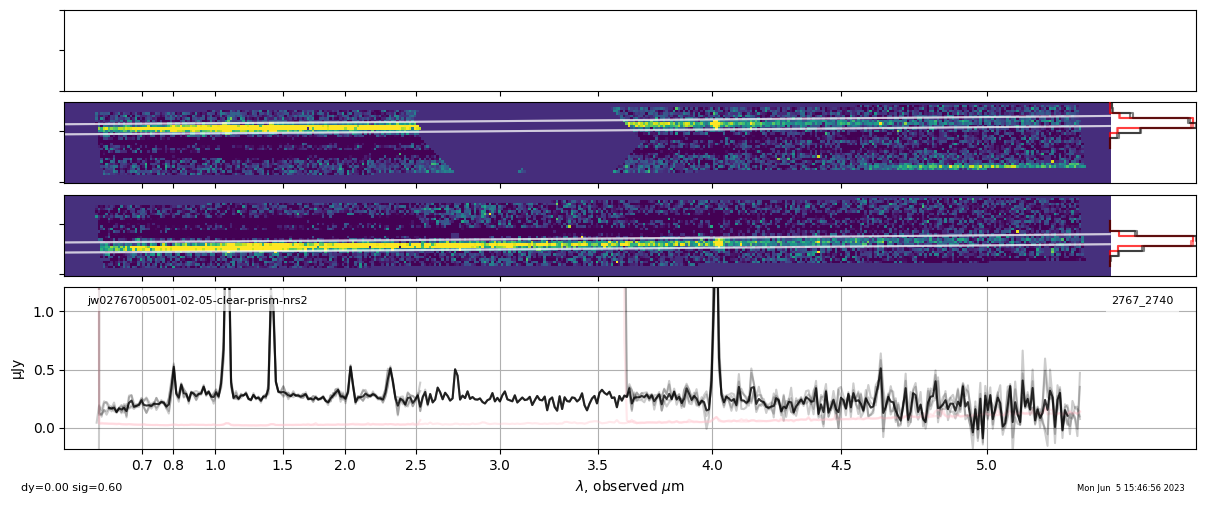

In [41]:
# Exclude first exposure
_ = pipe.extract_spectrum(key, skip=[0], yoffset=0, prof_sigma=0.6, trace_sign=-1, fit_profile_params=None)

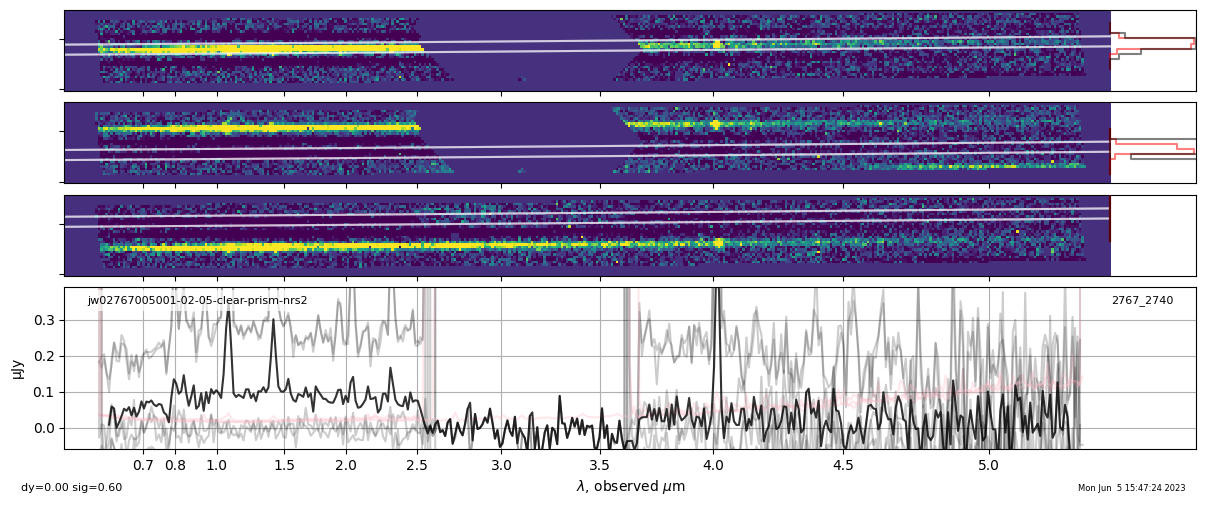

In [42]:
# Not quite sure why the sign flips
# maybe sign=-1 for prism, +1 otherwise?
_ = pipe.extract_spectrum(key, skip=[], yoffset=0, prof_sigma=0.6, trace_sign=1, fit_profile_params=None)

2023-06-05 21:16:56,444 - stpipe - WARNING - /Users/wmb629/opt/anaconda3/envs/jwst_pipe/lib/python3.11/site-packages/msaexp/pipeline.py:1163: OptimizeWarning: Unknown solver options: direc
2023-06-05 21:16:56,444 - stpipe - WARNING -   _res = minimize(_objfun_fit_profile, x0,
2023-06-05 21:16:56,445 - stpipe - WARNING - 


msaexp.fit_profile:      2767_2740             (dchi2 =   5959.0) yoffset = -0.14  prof_sigma = 0.70 dchi2 =    352.2


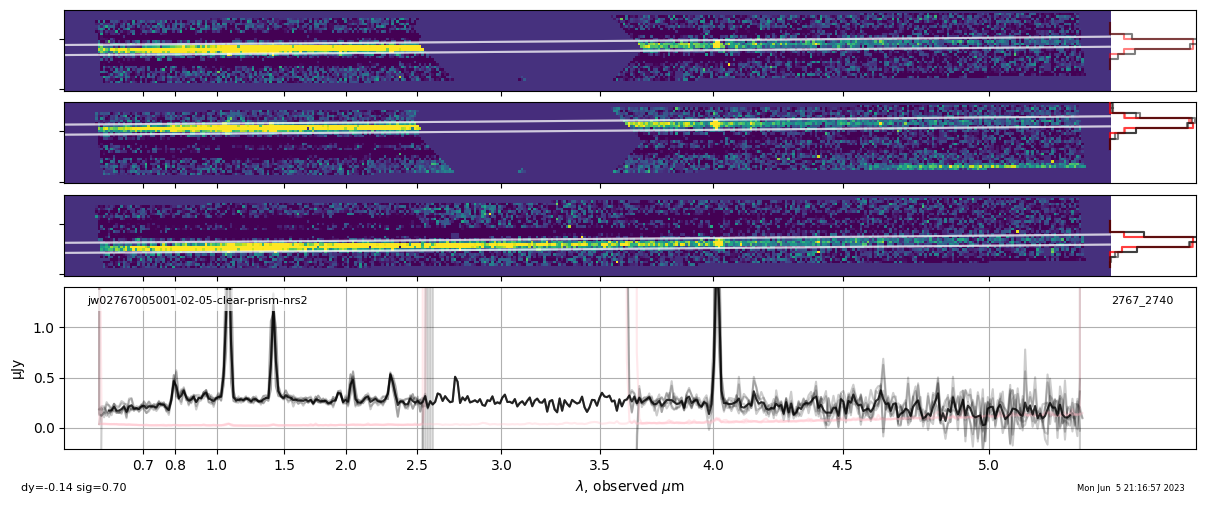

In [17]:
# Fit optimal profile
_data = pipe.extract_spectrum(key, skip=[], yoffset=0, prof_sigma=0.6, trace_sign=-1, 
                              fit_profile_params={'min_delta':20})
slitlet, sep1d, opt1d, fig = _data

## Drizzled 2D spectrum

In [22]:
# Get background-subtracted slitlets
slits = pipe.get_background_slits(key, step='bkg', check_background=True)
slits

[<SlitModel(32, 421) from jw02767005001_03105_00002_nrs2_phot.128.2767_2740.fits>,
 <SlitModel(32, 421) from jw02767005001_03105_00003_nrs2_phot.128.2767_2740.fits>,
 <SlitModel(32, 421) from jw02767005001_03105_00004_nrs2_phot.128.2767_2740.fits>]

In [23]:
import msaexp.utils

drizzle_params = dict(output=None,
                      single=True,
                      blendheaders=True,
                      pixfrac=0.5,
                      kernel='square',
                      fillval=0,
                      wht_type='ivm',
                      good_bits=0,
                      pscale_ratio=1.0,
                      pscale=None)

# Drizzle each exposure
kwargs = {'keep_wave':1}
wave, header, results = msaexp.utils.drizzle_slits_2d(slits, drizzle_params=drizzle_params, **kwargs)


build_regular_wavelength_wcs: Set linear wave grid (dlam=103.2 Ang)
Pad 2 pixels on 2D cutout


2023-06-05 21:41:18,900 - stpipe - INFO - Driz parameter kernal: square
2023-06-05 21:41:18,900 - stpipe - INFO - Driz parameter pixfrac: 0.5
2023-06-05 21:41:18,901 - stpipe - INFO - Driz parameter fillval: 0
2023-06-05 21:41:18,902 - stpipe - INFO - Driz parameter weight_type: ivm
2023-06-05 21:41:19,213 - stpipe - INFO - Blending metadata for None
2023-06-05 21:41:20,316 - stpipe - INFO - Resampling science data
2023-06-05 21:41:20,392 - stpipe - INFO - Drizzling (32, 421) --> (42, 421)
2023-06-05 21:41:20,397 - stpipe - INFO - Resampling var_rnoise
2023-06-05 21:41:20,467 - stpipe - INFO - Drizzling (32, 421) --> (42, 421)
2023-06-05 21:41:20,473 - stpipe - INFO - Resampling var_poisson
2023-06-05 21:41:20,543 - stpipe - INFO - Drizzling (32, 421) --> (42, 421)
2023-06-05 21:41:20,549 - stpipe - INFO - Resampling var_flat
2023-06-05 21:41:20,619 - stpipe - INFO - Drizzling (32, 421) --> (42, 421)
2023-06-05 21:41:20,832 - stpipe - INFO - Blending metadata for None
2023-06-05 21:41:

In [24]:
# Combine drizzled products with outlier rejection
prf_kwargs = {'prf_center':None, 'prf_sigma':0.6, 'fit_prf':True}
sci2d, wht2d, p2d, spec, prof = msaexp.utils.combine_2d_with_rejection(results,
                                                                       outlier_threshold=20,
                                                                       **prf_kwargs)

2023-06-05 21:41:41,138 - stpipe - WARNING - /Users/wmb629/opt/anaconda3/envs/jwst_pipe/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
2023-06-05 21:41:41,139 - stpipe - WARNING -   return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
2023-06-05 21:41:41,140 - stpipe - WARNING - 


Set prf_center: 1.0 (42, 421) 10
fit_prf: center = 0.62. sigma = 0.97


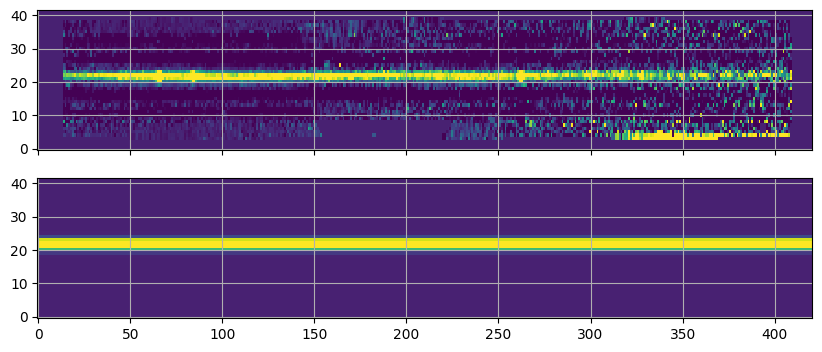

In [25]:
fig, axes = plt.subplots(2,1,figsize=(10,4), sharex=True)
axes[0].imshow(sci2d, vmin=-0.01, vmax=0.1, origin='lower', aspect='auto')
axes[1].imshow(p2d, vmin=-0.01, vmax=0.1, origin='lower', aspect='auto')
for ax in axes:
    ax.grid()

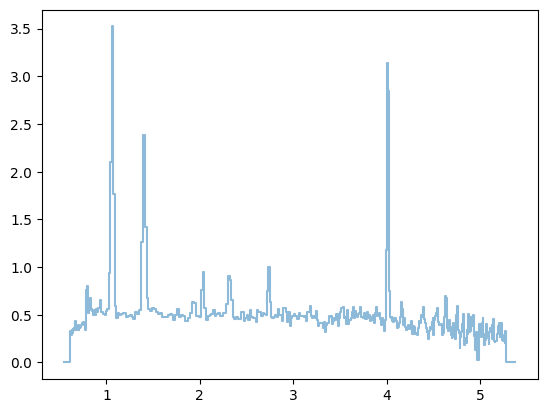

In [26]:
plt.step(spec['wave'], spec['flux'], alpha=0.5)

In [27]:
# Drizzle to a grid that oversamples the wavelengths by x2
kwargs = {'keep_wave':2}
wave2, header2, results2 = msaexp.utils.drizzle_slits_2d(slits, drizzle_params=drizzle_params, **kwargs)

build_regular_wavelength_wcs: Oversample original wavelength grid x 2
Pad 2 pixels on 2D cutout


2023-06-05 21:42:05,686 - stpipe - INFO - Driz parameter kernal: square
2023-06-05 21:42:05,686 - stpipe - INFO - Driz parameter pixfrac: 0.5
2023-06-05 21:42:05,687 - stpipe - INFO - Driz parameter fillval: 0
2023-06-05 21:42:05,687 - stpipe - INFO - Driz parameter weight_type: ivm
2023-06-05 21:42:06,295 - stpipe - INFO - Blending metadata for None
2023-06-05 21:42:07,436 - stpipe - INFO - Resampling science data
2023-06-05 21:42:07,499 - stpipe - INFO - Drizzling (32, 421) --> (42, 841)
2023-06-05 21:42:07,504 - stpipe - INFO - Resampling var_rnoise
2023-06-05 21:42:07,574 - stpipe - INFO - Drizzling (32, 421) --> (42, 841)
2023-06-05 21:42:07,580 - stpipe - INFO - Resampling var_poisson
2023-06-05 21:42:07,650 - stpipe - INFO - Drizzling (32, 421) --> (42, 841)
2023-06-05 21:42:07,657 - stpipe - INFO - Resampling var_flat
2023-06-05 21:42:07,737 - stpipe - INFO - Drizzling (32, 421) --> (42, 841)
2023-06-05 21:42:07,944 - stpipe - INFO - Blending metadata for None
2023-06-05 21:42:

In [28]:
prf_kwargs = {'prf_center':None, 'prf_sigma':0.6, 'fit_prf':True}
sci2d2, wht2d2, p2d2, spec2, prof = msaexp.utils.combine_2d_with_rejection(results2, sigma=5, **prf_kwargs)

2023-06-05 21:42:20,014 - stpipe - WARNING - /Users/wmb629/opt/anaconda3/envs/jwst_pipe/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
2023-06-05 21:42:20,015 - stpipe - WARNING -   return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
2023-06-05 21:42:20,015 - stpipe - WARNING - 


Set prf_center: 1.0 (42, 841) 10
fit_prf: center = 0.61. sigma = 0.97


(3.9, 4.1)

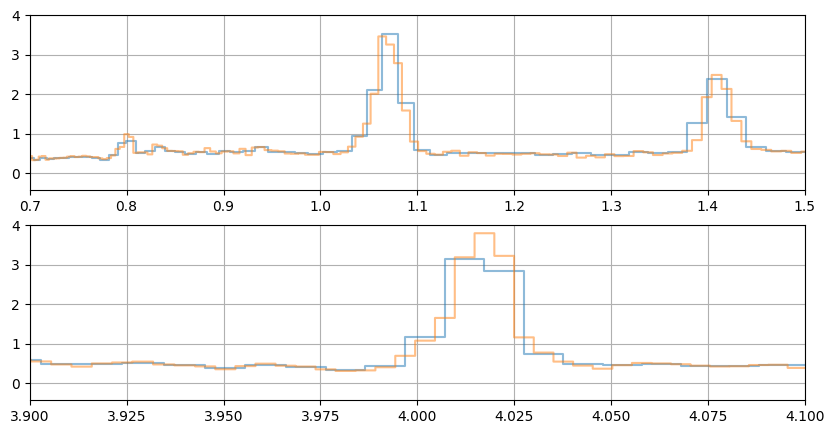

In [29]:
fig, axes = plt.subplots(2,1, figsize=(10, 5))
for ax in axes:
    ax.step(spec['wave'], spec['flux'], alpha=0.5, where='mid')
    ax.step(spec2['wave'], spec2['flux'], alpha=0.5, where='mid')
    ax.grid()

axes[0].set_xlim(0.7, 1.5)
axes[1].set_xlim(3.9, 4.1)

# 2D drizzle helper

`msaexp.utils.drizzle_2d_pipeline` does the 2D drizzle steps above and wraps the output into a FITS HDU

In [30]:
outroot = 'rxj2129'
file_version = 'v'+msaexp.__version__.split('+')[0]
print(outroot, file_version)

rxj2129 v0.6.11


outlier_threshold:  7.0
msaexp.drizzle.drizzle_slitlets: 2767_2740 read 3 files
msaexp.drizzle.drizzle_slitlets: id=2767_2740  prism-clear N=3
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2767_2740


2023-06-05 21:43:54,712 - stpipe - INFO - Driz parameter kernal: square
2023-06-05 21:43:54,712 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-06-05 21:43:54,713 - stpipe - INFO - Driz parameter fillval: 0
2023-06-05 21:43:54,713 - stpipe - INFO - Driz parameter weight_type: ivm
2023-06-05 21:43:55,032 - stpipe - INFO - Blending metadata for None
2023-06-05 21:43:56,403 - stpipe - INFO - Resampling science data
2023-06-05 21:43:56,482 - stpipe - INFO - Drizzling (32, 421) --> (31, 435)
2023-06-05 21:43:56,488 - stpipe - INFO - Resampling var_rnoise
2023-06-05 21:43:56,560 - stpipe - INFO - Drizzling (32, 421) --> (31, 435)
2023-06-05 21:43:56,568 - stpipe - INFO - Resampling var_poisson
2023-06-05 21:43:56,641 - stpipe - INFO - Drizzling (32, 421) --> (31, 435)
2023-06-05 21:43:56,649 - stpipe - INFO - Resampling var_flat
2023-06-05 21:43:56,724 - stpipe - INFO - Drizzling (32, 421) --> (31, 435)
2023-06-05 21:43:58,134 - stpipe - INFO - Driz parameter kernal: square
2023-06-05 21:

msaexp.drizzle.drizzle_slitlets: output size = (31, 435)
msaexp.drizzle.drizzle_slitlets: prism-clear  0 2767_2740               2740 -0.079 <SlitModel(32, 421) from jw02767005001_03105_00002_nrs2_phot.128.2767_2740.fits> (32, 421)


2023-06-05 21:44:01,462 - stpipe - INFO - Driz parameter kernal: square
2023-06-05 21:44:01,463 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-06-05 21:44:01,464 - stpipe - INFO - Driz parameter fillval: 0
2023-06-05 21:44:01,465 - stpipe - INFO - Driz parameter weight_type: ivm
2023-06-05 21:44:02,490 - stpipe - INFO - Blending metadata for None
2023-06-05 21:44:04,522 - stpipe - INFO - Resampling science data
2023-06-05 21:44:04,620 - stpipe - INFO - Drizzling (32, 421) --> (31, 435)
2023-06-05 21:44:04,627 - stpipe - INFO - Resampling var_rnoise
2023-06-05 21:44:04,762 - stpipe - INFO - Drizzling (32, 421) --> (31, 435)
2023-06-05 21:44:04,770 - stpipe - INFO - Resampling var_poisson
2023-06-05 21:44:04,875 - stpipe - INFO - Drizzling (32, 421) --> (31, 435)
2023-06-05 21:44:04,885 - stpipe - INFO - Resampling var_flat
2023-06-05 21:44:04,973 - stpipe - INFO - Drizzling (32, 421) --> (31, 435)


msaexp.drizzle.drizzle_slitlets: prism-clear  1 2767_2740               2740 -0.091 <SlitModel(32, 421) from jw02767005001_03105_00003_nrs2_phot.128.2767_2740.fits> (32, 421)


2023-06-05 21:44:05,259 - stpipe - INFO - Driz parameter kernal: square
2023-06-05 21:44:05,260 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-06-05 21:44:05,261 - stpipe - INFO - Driz parameter fillval: 0
2023-06-05 21:44:05,262 - stpipe - INFO - Driz parameter weight_type: ivm
2023-06-05 21:44:05,597 - stpipe - INFO - Blending metadata for None
2023-06-05 21:44:06,832 - stpipe - INFO - Resampling science data
2023-06-05 21:44:06,902 - stpipe - INFO - Drizzling (32, 421) --> (31, 435)
2023-06-05 21:44:06,907 - stpipe - INFO - Resampling var_rnoise
2023-06-05 21:44:06,980 - stpipe - INFO - Drizzling (32, 421) --> (31, 435)
2023-06-05 21:44:06,987 - stpipe - INFO - Resampling var_poisson
2023-06-05 21:44:07,058 - stpipe - INFO - Drizzling (32, 421) --> (31, 435)
2023-06-05 21:44:07,069 - stpipe - INFO - Resampling var_flat
2023-06-05 21:44:07,170 - stpipe - INFO - Drizzling (32, 421) --> (31, 435)


msaexp.drizzle.drizzle_slitlets: prism-clear  2 2767_2740               2740 -0.067 <SlitModel(32, 421) from jw02767005001_03105_00004_nrs2_phot.128.2767_2740.fits> (32, 421)


2023-06-05 21:44:07,459 - stpipe - INFO - Driz parameter kernal: square
2023-06-05 21:44:07,460 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-06-05 21:44:07,461 - stpipe - INFO - Driz parameter fillval: 0
2023-06-05 21:44:07,462 - stpipe - INFO - Driz parameter weight_type: ivm
2023-06-05 21:44:08,079 - stpipe - INFO - Blending metadata for None
2023-06-05 21:44:09,208 - stpipe - INFO - Resampling science data
2023-06-05 21:44:09,287 - stpipe - INFO - Drizzling (32, 421) --> (31, 435)
2023-06-05 21:44:09,291 - stpipe - INFO - Resampling var_rnoise
2023-06-05 21:44:09,367 - stpipe - INFO - Drizzling (32, 421) --> (31, 435)
2023-06-05 21:44:09,374 - stpipe - INFO - Resampling var_poisson
2023-06-05 21:44:09,447 - stpipe - INFO - Drizzling (32, 421) --> (31, 435)
2023-06-05 21:44:09,454 - stpipe - INFO - Resampling var_flat
2023-06-05 21:44:09,528 - stpipe - INFO - Drizzling (32, 421) --> (31, 435)
2023-06-05 21:44:09,570 - stpipe - WARNING - VerifyWarning: Card is too long, comment 

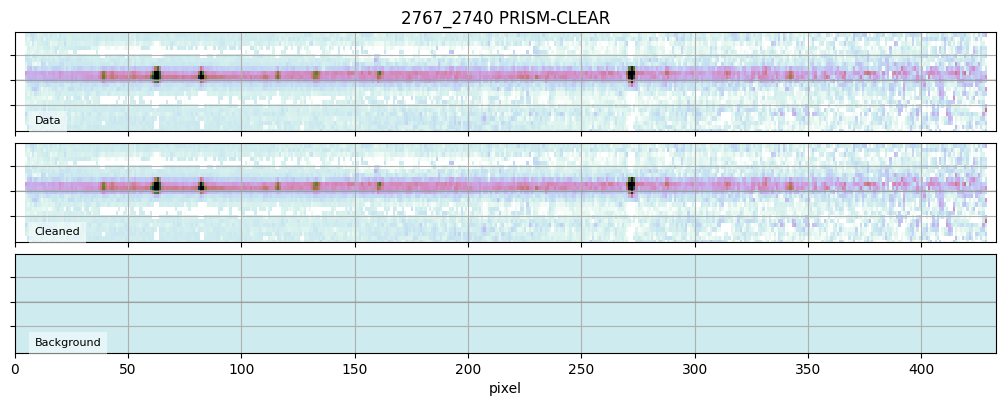

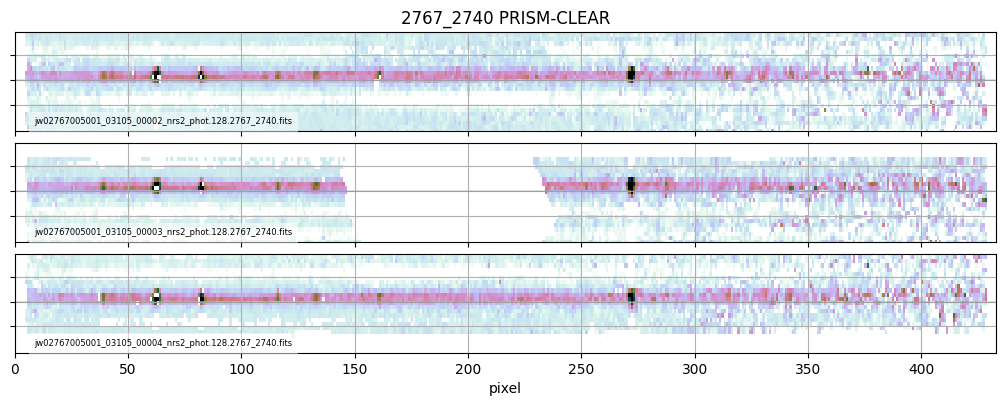

In [31]:
# Drizzle slitlets
from importlib import reload
import copy

import msaexp.drizzle
reload(msaexp.drizzle); reload(msaexp.utils)
reload(msaexp.drizzle); reload(msaexp.utils) 

DRIZZLE_PARAMS = copy.deepcopy(msaexp.drizzle.DRIZZLE_PARAMS)
DRIZZLE_PARAMS['kernel'] = 'square'
DRIZZLE_PARAMS['pixfrac'] = 0.8

target = key

wave_sample = 1.05
wave_arrays = {}

# Don't do background subtraction because it was done above
master_bkg = 0
bkg_parity = []

# flexible outlier threshold based on S/N
sn = slits[0].data / slits[0].err
outlier_threshold = np.clip(np.nanpercentile(sn[slits[0].err > 0], 90)*2, 7, 100)
print('outlier_threshold: ', outlier_threshold)

if target == '2750_355':
    slits = slits[1:]
    
_ = msaexp.drizzle.drizzle_slitlets(target,
                                    output=outroot,
                                    files=slits,
                                    center_on_source=False,  # Center output source as defined in MSA file.  Leave False and can maybe build master bkg
                                    fix_slope=0.2,          # Cross-dispersion scale dslit/dpix
                                    force_nypix=31,         # Y size of output array
                                    bkg_offset=6,           # Number of pixels to roll for background subtraction
                                    bkg_parity=bkg_parity,  # Roll directions for background, i.e., -1 rolls the array down for bkg at top
                                    master_bkg=master_bkg,  # If 0, then assumes background already subtracted in A-B, B-A above
                                    log_step=False,         # Log wavelength steps
                                    outlier_threshold=outlier_threshold,   # Outlier rejection threshold
                                    err_threshold=1000,     # Reject pixels in a slit where err > err_threshold*median(err)
                                    show_drizzled=True,     # Figures
                                    show_slits=True,
                                    imshow_kws=dict(vmin=-0.05, vmax=0.4, aspect='auto', cmap='cubehelix_r'),
                                    sn_threshold=-np.inf,   # Reject pixels where S/N < sn_threshold.  Prism S/N should usually be > 5 with bkg
                                    bar_threshold=0.0,      # Mask pixels where barshadow array less than this value
                                    drizzle_params=DRIZZLE_PARAMS,
                                    wave_sample=wave_sample,
                                    wave_arrays=wave_arrays,
                                    center_phase=-0.5,
                                   )

figs, hdu_data, wavedata, all_slits, drz_data = _

msaexp.drizzle.extract_from_hdul: Initial center =    0.38, sigma =   0.90
msaexp.drizzle.extract_from_hdul: dchi2/dcenter = 44279.5
msaexp.drizzle.extract_from_hdul:  Output center =    1.37, sigma =   0.94


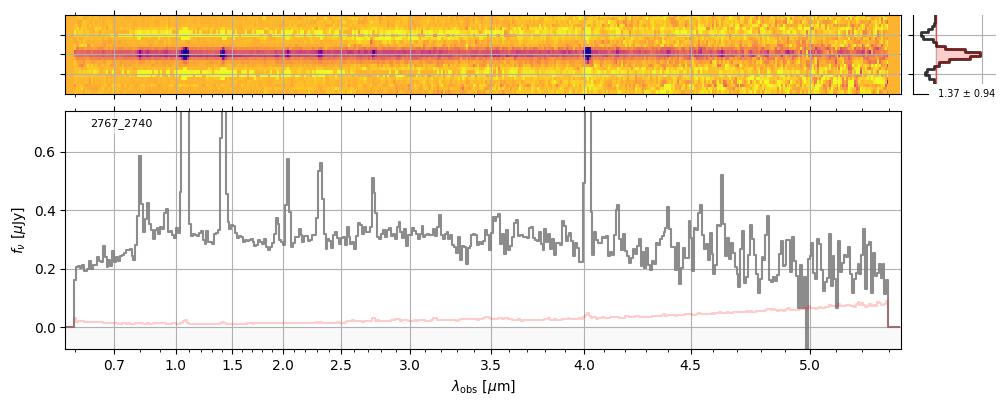

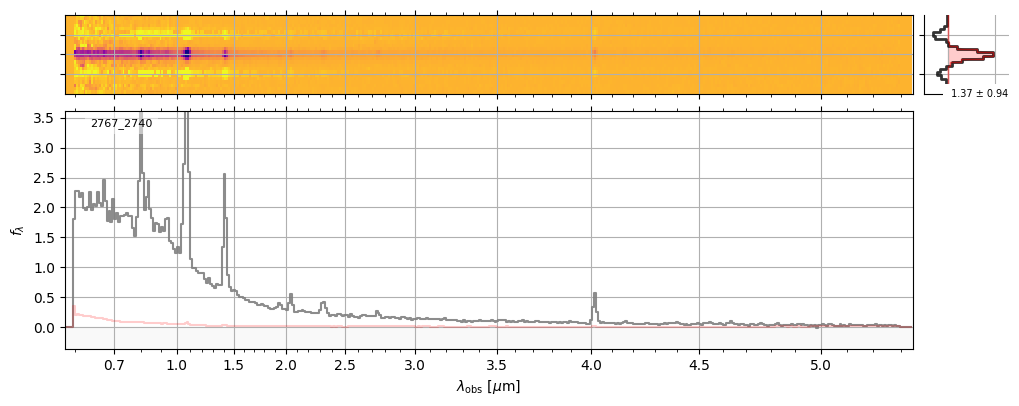

In [32]:
# Plot drizzled result

hdul = hdu_data['prism-clear']

if target in ['2750_355']:
    kws = dict(prf_sigma=0.9, fix_sigma=False,
               prf_center=0.2, fix_center=False,
               verbose=True,
               sigma_bounds=(0.4, 2.5)
              )
elif target in ['2750_64']:
    kws = dict(prf_sigma=0.9, fix_sigma=False,
               prf_center=2, fix_center=True,
               verbose=True,
               sigma_bounds=(0.4, 2.5)
              )
elif target in ['2750_69']:
    kws = dict(prf_sigma=0.9, fix_sigma=False,
               prf_center=0.5, fix_center=True,
               verbose=True,
               sigma_bounds=(0.4, 2.5)
              )
else:
    kws = dict(prf_sigma=0.9, fix_sigma=False,
               prf_center=None, fix_center=False,
               verbose=True,
               sigma_bounds=(0.4, 2.5)
              )

outhdu = msaexp.drizzle.extract_from_hdul(hdul, **kws)

outhdu.writeto(f'{outroot}_{target}.{file_version}.spec.fits', overwrite=True)

# Make figures
fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='fnu')
fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')

fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='flam')
fig.savefig(f'{outroot}_{target}.{file_version}.flam.png')


In [33]:
outhdu.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPEC1D        1 BinTableHDU    185   435R x 3C   ['D', 'D', 'D']   
  2  SCI           1 ImageHDU       175   (435, 31)   float32   
  3  WHT           1 ImageHDU       175   (435, 31)   float32   
  4  PROFILE       1 ImageHDU       175   (435, 31)   float64   
  5  PROF1D        1 BinTableHDU     25   31R x 3C   ['D', 'E', 'D']   


In [32]:
# Deprecated drizzling
if False:
    import grizli.utils
    grizli.utils.set_warnings()

    DRIZZLE_PARAMS = dict(output=None,
                          single=True,
                          blendheaders=True,
                          pixfrac=0.6,
                          kernel='square',
                          fillval=0,
                          wht_type='ivm',
                          good_bits=0,
                          pscale_ratio=1.0,
                          pscale=None)

    slits = pipe.get_background_slits(key, step='bkg', check_background=True)

    hdul = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=DRIZZLE_PARAMS,
                                            fit_prf=True,
                                            outlier_threshold=5,
                                            prf_center=None, prf_sigma=0.6, center_limit=4, 
                                            standard_waves=1)

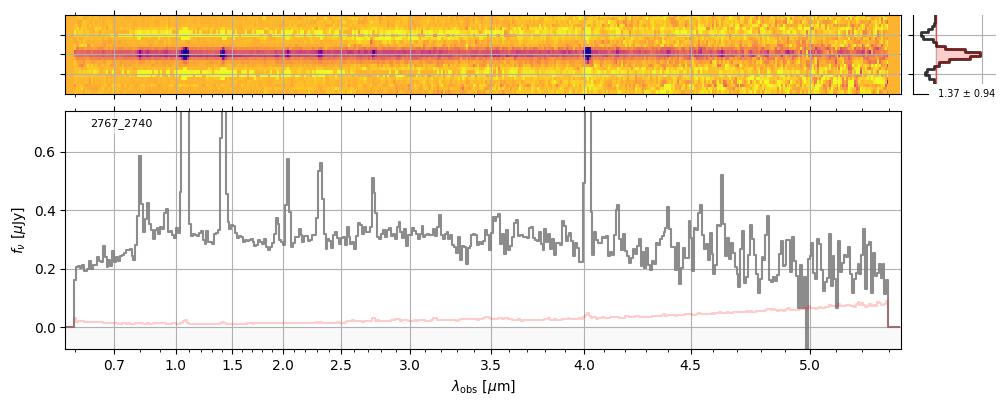

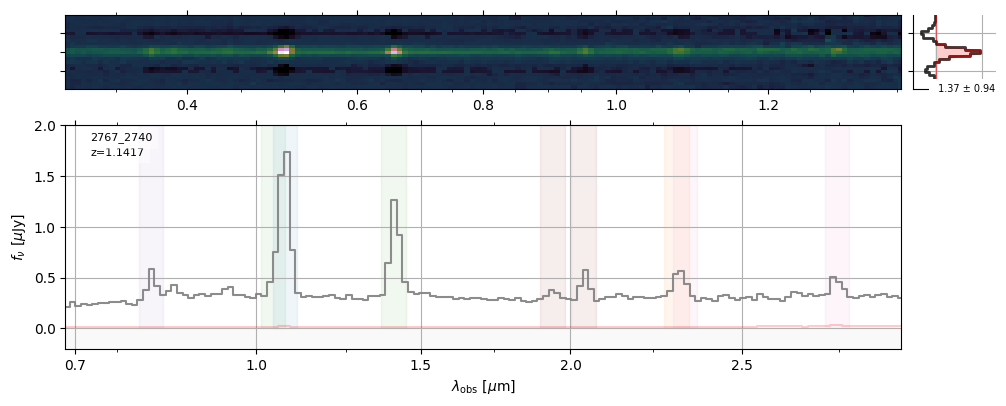

In [34]:
# Make figures showing 2D / 1D spectra
_fig = msaexp.utils.drizzled_hdu_figure(outhdu, xlim=None)

# Other plot options
_fig = msaexp.utils.drizzled_hdu_figure(outhdu, xlim=(0.69, 2.9), # zoom on wavelength range
                                        tick_steps=[0.5, 0.25], # major, minor
                                        ymax=2,   # y extent of plot and 2D scaling
                                        z=1.1417, # indicate strong lines for a given redshift
                                        cmap='cubehelix')


In [35]:
import astropy.table
prof = astropy.table.Table(outhdu['PROF1D'].data)

In [36]:
outhdu['PROFILE'].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  435                                                  
NAXIS2  =                   31                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
CRPIX1  =                  218                                                  
CRPIX2  =                   16                                                  
CRPIX3  =                    1                                                  
CRVAL1  =    34478.17210692866                                                  
CRVAL2  =    322.4199176379977                                                  
CRVAL3  =    0.1016015119620

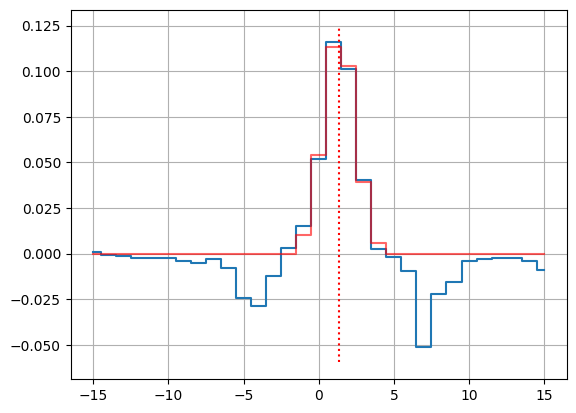

In [37]:
# Show the optimal extraction profile

plt.step(prof['pix'], prof['profile'], where='mid', label='Profile data')
plt.step(prof['pix'], prof['pfit'], where='mid', label='Profile data', color='r', alpha=0.6)

plt.vlines(outhdu['PROFILE'].header['PROFCEN'],
           *plt.ylim(), color='r', linestyle=':')
plt.grid()

# z=9.5 source from Williams et al.

3

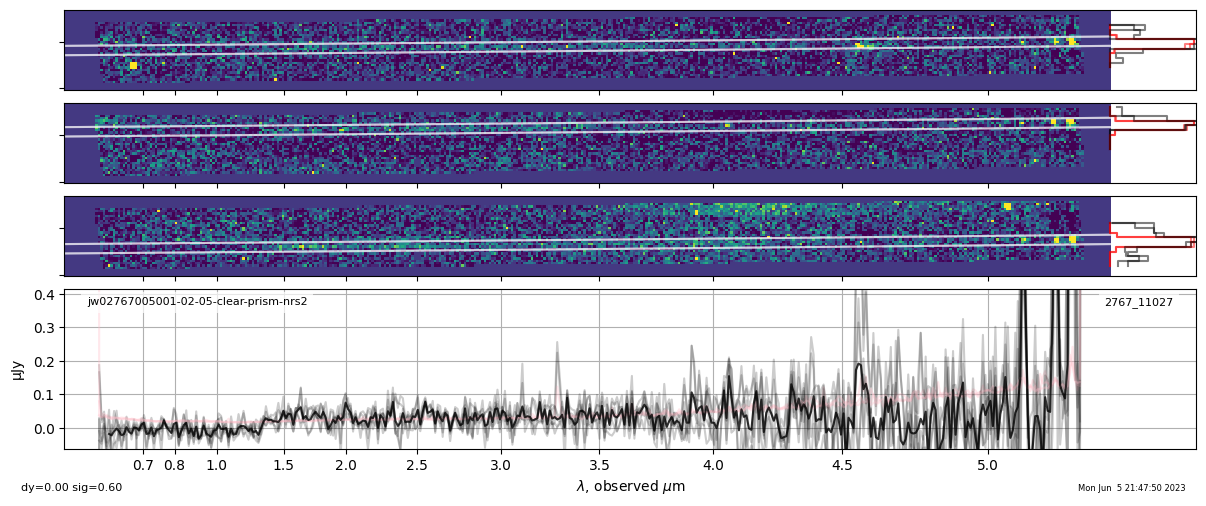

In [38]:
key = '2767_11027'

_ = pipe.extract_spectrum(key, skip=[], yoffset=0, prof_sigma=0.6, trace_sign=-1, fit_profile_params=None)

slits = pipe.get_background_slits(key, step='bkg', check_background=True)
len(slits)

msaexp.drizzle.drizzle_slitlets: 2767_2740 read 3 files
msaexp.drizzle.drizzle_slitlets: id=2767_2740  prism-clear N=3
msaexp.drizzle.drizzle_slitlets: get wcs from slit 0 =  2767_11027


2023-06-05 21:48:26,476 - stpipe - INFO - Driz parameter kernal: square
2023-06-05 21:48:26,477 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-06-05 21:48:26,478 - stpipe - INFO - Driz parameter fillval: 0
2023-06-05 21:48:26,478 - stpipe - INFO - Driz parameter weight_type: ivm
2023-06-05 21:48:26,801 - stpipe - INFO - Blending metadata for None
2023-06-05 21:48:28,026 - stpipe - INFO - Resampling science data
2023-06-05 21:48:28,103 - stpipe - INFO - Drizzling (34, 421) --> (31, 435)
2023-06-05 21:48:28,109 - stpipe - INFO - Resampling var_rnoise
2023-06-05 21:48:28,192 - stpipe - INFO - Drizzling (34, 421) --> (31, 435)
2023-06-05 21:48:28,200 - stpipe - INFO - Resampling var_poisson
2023-06-05 21:48:28,277 - stpipe - INFO - Drizzling (34, 421) --> (31, 435)
2023-06-05 21:48:28,285 - stpipe - INFO - Resampling var_flat
2023-06-05 21:48:28,359 - stpipe - INFO - Drizzling (34, 421) --> (31, 435)
2023-06-05 21:48:29,745 - stpipe - INFO - Driz parameter kernal: square
2023-06-05 21:

msaexp.drizzle.drizzle_slitlets: output size = (31, 435)
msaexp.drizzle.drizzle_slitlets: prism-clear  0 2767_11027             11027 -0.081 <SlitModel(34, 421) from jw02767005001_03105_00002_nrs2_phot.109.2767_11027.fits> (34, 421)


2023-06-05 21:48:32,061 - stpipe - INFO - Driz parameter kernal: square
2023-06-05 21:48:32,062 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-06-05 21:48:32,063 - stpipe - INFO - Driz parameter fillval: 0
2023-06-05 21:48:32,063 - stpipe - INFO - Driz parameter weight_type: ivm
2023-06-05 21:48:32,408 - stpipe - INFO - Blending metadata for None
2023-06-05 21:48:33,513 - stpipe - INFO - Resampling science data
2023-06-05 21:48:33,906 - stpipe - INFO - Drizzling (34, 421) --> (31, 435)
2023-06-05 21:48:33,911 - stpipe - INFO - Resampling var_rnoise
2023-06-05 21:48:33,988 - stpipe - INFO - Drizzling (34, 421) --> (31, 435)
2023-06-05 21:48:33,995 - stpipe - INFO - Resampling var_poisson
2023-06-05 21:48:34,069 - stpipe - INFO - Drizzling (34, 421) --> (31, 435)
2023-06-05 21:48:34,076 - stpipe - INFO - Resampling var_flat
2023-06-05 21:48:34,156 - stpipe - INFO - Drizzling (34, 421) --> (31, 435)


msaexp.drizzle.drizzle_slitlets: prism-clear  1 2767_11027             11027 -0.089 <SlitModel(34, 421) from jw02767005001_03105_00003_nrs2_phot.109.2767_11027.fits> (34, 421)


2023-06-05 21:48:34,456 - stpipe - INFO - Driz parameter kernal: square
2023-06-05 21:48:34,457 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-06-05 21:48:34,458 - stpipe - INFO - Driz parameter fillval: 0
2023-06-05 21:48:34,458 - stpipe - INFO - Driz parameter weight_type: ivm
2023-06-05 21:48:34,796 - stpipe - INFO - Blending metadata for None
2023-06-05 21:48:35,914 - stpipe - INFO - Resampling science data
2023-06-05 21:48:35,994 - stpipe - INFO - Drizzling (34, 421) --> (31, 435)
2023-06-05 21:48:35,999 - stpipe - INFO - Resampling var_rnoise
2023-06-05 21:48:36,075 - stpipe - INFO - Drizzling (34, 421) --> (31, 435)
2023-06-05 21:48:36,082 - stpipe - INFO - Resampling var_poisson
2023-06-05 21:48:36,159 - stpipe - INFO - Drizzling (34, 421) --> (31, 435)
2023-06-05 21:48:36,167 - stpipe - INFO - Resampling var_flat
2023-06-05 21:48:36,247 - stpipe - INFO - Drizzling (34, 421) --> (31, 435)


msaexp.drizzle.drizzle_slitlets: prism-clear  2 2767_11027             11027 -0.073 <SlitModel(34, 421) from jw02767005001_03105_00004_nrs2_phot.109.2767_11027.fits> (34, 421)


2023-06-05 21:48:36,544 - stpipe - INFO - Driz parameter kernal: square
2023-06-05 21:48:36,545 - stpipe - INFO - Driz parameter pixfrac: 0.8
2023-06-05 21:48:36,546 - stpipe - INFO - Driz parameter fillval: 0
2023-06-05 21:48:36,546 - stpipe - INFO - Driz parameter weight_type: ivm
2023-06-05 21:48:36,896 - stpipe - INFO - Blending metadata for None
2023-06-05 21:48:37,997 - stpipe - INFO - Resampling science data
2023-06-05 21:48:38,065 - stpipe - INFO - Drizzling (34, 421) --> (31, 435)
2023-06-05 21:48:38,070 - stpipe - INFO - Resampling var_rnoise
2023-06-05 21:48:38,461 - stpipe - INFO - Drizzling (34, 421) --> (31, 435)
2023-06-05 21:48:38,467 - stpipe - INFO - Resampling var_poisson
2023-06-05 21:48:38,540 - stpipe - INFO - Drizzling (34, 421) --> (31, 435)
2023-06-05 21:48:38,547 - stpipe - INFO - Resampling var_flat
2023-06-05 21:48:38,620 - stpipe - INFO - Drizzling (34, 421) --> (31, 435)
2023-06-05 21:48:38,660 - stpipe - WARNING - VerifyWarning: Card is too long, comment 

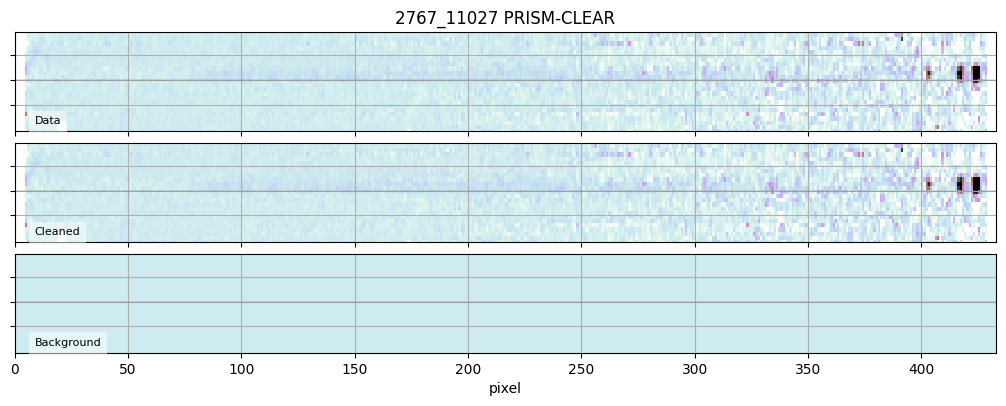

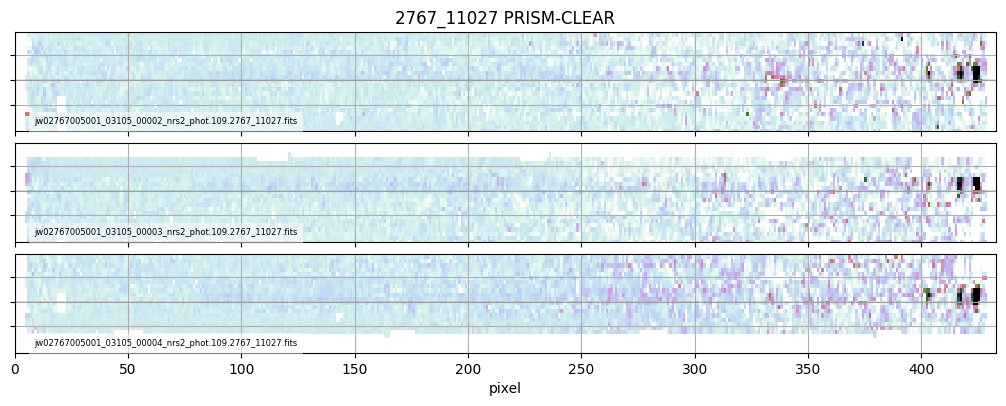

In [39]:
_ = msaexp.drizzle.drizzle_slitlets(target,
                                    output=outroot,
                                    files=slits,
                                    center_on_source=False,  # Center output source as defined in MSA file.  Leave False and can maybe build master bkg
                                    fix_slope=0.2,          # Cross-dispersion scale dslit/dpix
                                    force_nypix=31,         # Y size of output array
                                    bkg_offset=6,           # Number of pixels to roll for background subtraction
                                    bkg_parity=bkg_parity,  # Roll directions for background, i.e., -1 rolls the array down for bkg at top
                                    master_bkg=master_bkg,  # If 0, then assumes background already subtracted in A-B, B-A above
                                    log_step=False,         # Log wavelength steps
                                    outlier_threshold=outlier_threshold,   # Outlier rejection threshold
                                    err_threshold=1000,     # Reject pixels in a slit where err > err_threshold*median(err)
                                    show_drizzled=True,     # Figures
                                    show_slits=True,
                                    imshow_kws=dict(vmin=-0.05, vmax=0.4, aspect='auto', cmap='cubehelix_r'),
                                    sn_threshold=-np.inf,   # Reject pixels where S/N < sn_threshold.  Prism S/N should usually be > 5 with bkg
                                    bar_threshold=0.0,      # Mask pixels where barshadow array less than this value
                                    drizzle_params=DRIZZLE_PARAMS,
                                    wave_sample=wave_sample,
                                    wave_arrays=wave_arrays,
                                    center_phase=-0.5,
                                   )

figs, hdu_data, wavedata, all_slits, drz_data = _


msaexp.drizzle.extract_from_hdul: Initial center =    0.39, sigma =   0.90
msaexp.drizzle.extract_from_hdul: dchi2/dcenter = 260.2
msaexp.drizzle.extract_from_hdul:  Output center =    1.62, sigma =   0.68


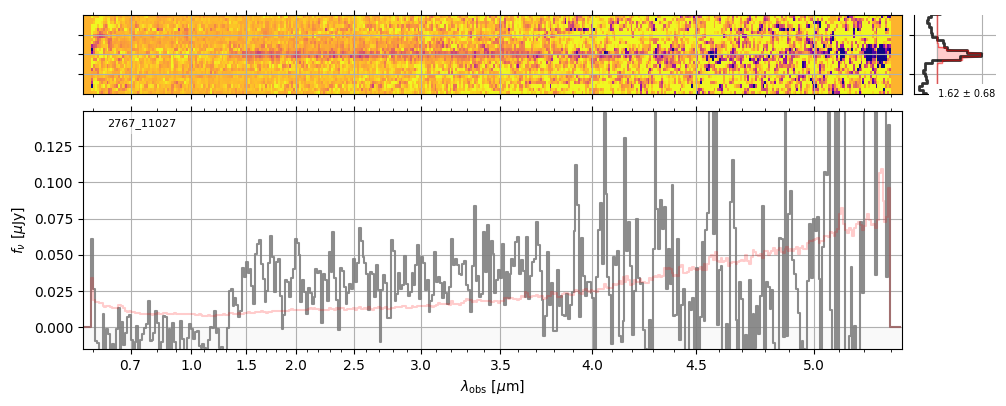

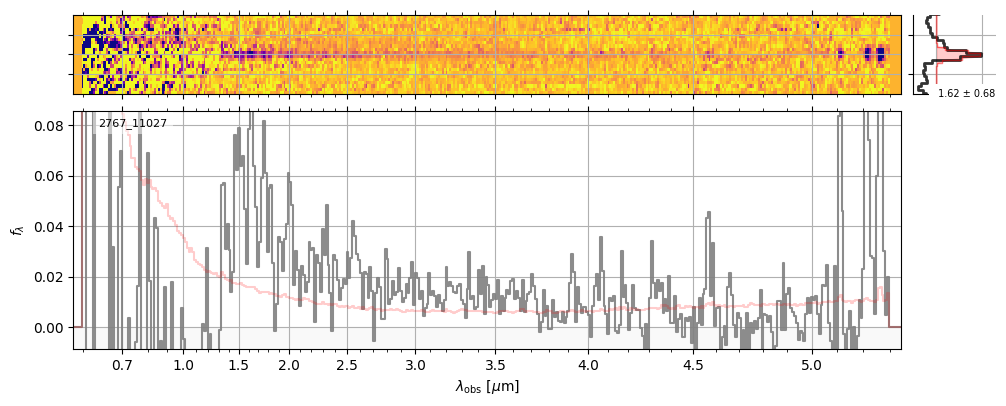

In [40]:
# Plot drizzled result

hdul = hdu_data['prism-clear']

outhdu = msaexp.drizzle.extract_from_hdul(hdul, **kws)

outhdu.writeto(f'{outroot}_{target}.{file_version}.spec.fits', overwrite=True)

# Make figures
fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='fnu')
fig.savefig(f'{outroot}_{target}.{file_version}.fnu.png')

fig = msaexp.utils.drizzled_hdu_figure(outhdu, unit='flam')
fig.savefig(f'{outroot}_{target}.{file_version}.flam.png')


## Fit redshift

In [40]:
import eazy
reload(eazy)

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs()
    
otempl = eazy.templates.read_templates_file('templates/sfhz/blue_sfhz_13.param')[:]

templ = [otempl[i].smooth_velocity(3.e5/250, in_place=False, smoothspec_kwargs={'fftsmooth': False}) 
         for i in [-1]]


2023-03-30 17:43:53,649 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/eazy/templates.py:356: ResourceWarning: unclosed file <_io.TextIOWrapper name='templates/sfhz/blue_sfhz_13.param' mode='r' encoding='UTF-8'>
  lines = open(templates_file).readlines()



201it [00:00, 312.12it/s]
34it [00:00, 334.48it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# rxj2129_2767_2740.v0.6.8.dev1.spec.fits
# z = 9.50984
# Thu Mar 30 17:43:55 2023
             line Hb      135.7 ±     12.0
             line Hg        0.0 ±      0.0
             line Hd        0.0 ±      0.0
     line NeIII-3968        0.0 ±      0.0
      line OIII-4959      218.8 ±     13.4
      line OIII-5007      652.5 ±     22.6
      line OIII-4363        0.0 ±      0.0
            line OII        0.0 ±      0.0
      line HeII-4687        3.7 ±      9.3
     line NeIII-3867        0.0 ±      0.0
       line HeI-3889        0.0 ±      0.0
      line OIII-1663      116.8 ±     35.2
      line CIII-1908       89.0 ±     27.2
      line NIII-1750       -3.4 ±     33.2
            line Lya     -605.5 ±    135.0
           line MgII       -3.8 ±     13.7
       line NeV-3346        0.3 ±      8.5
      line NeVI-3426       14.1 ±      8.2


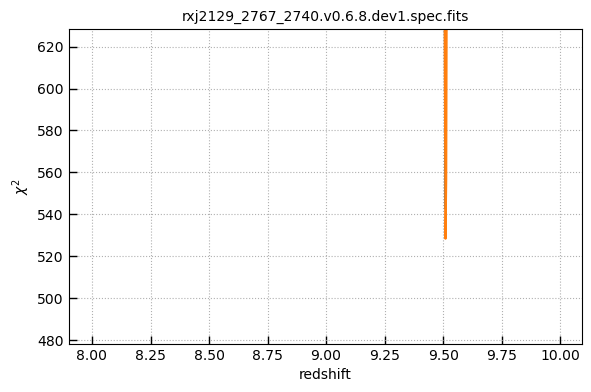

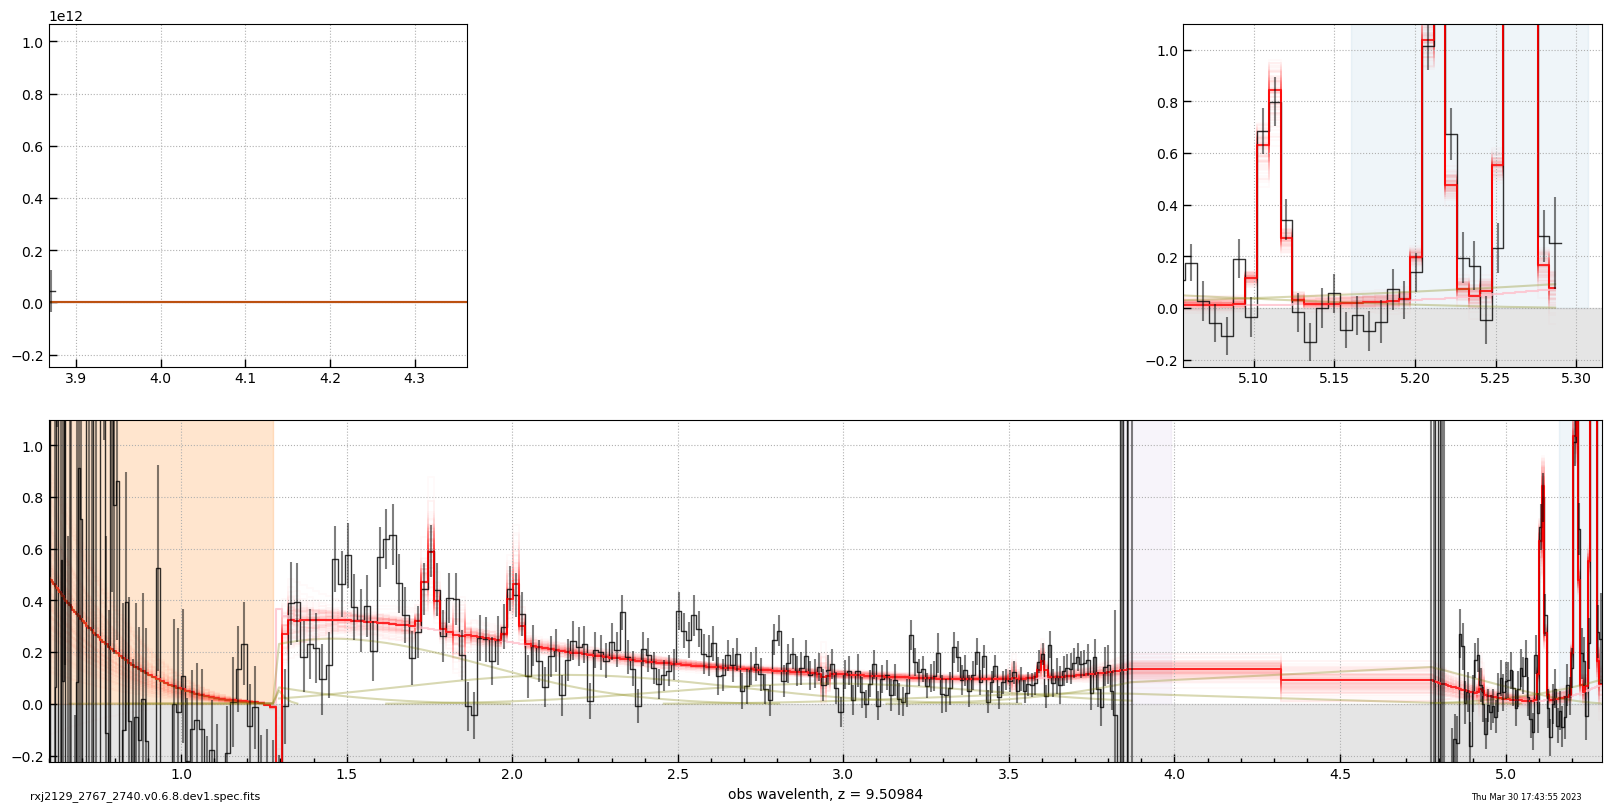

In [41]:
from msaexp import spectrum
#spectrum.SCALE_UNCERTAINTY = 1

spectrum.FFTSMOOTH = False

spec_file = f'{outroot}_{target}.{file_version}.spec.fits'

fig, sp, data = spectrum.fit_redshift(file=spec_file,
                          z0=[8.,10], 
                          zstep=[0.001,0.0003],
                          eazy_templates=None,
                          nspline=9,
                          scale_disp=1.3,
                          vel_width=50.,
                          Rline=2000,
                          is_prism=True,
                          use_full_dispersion=False,
                          ranges=[(3680, 4150), (4300, 4400), (4861-50, 5008+50)],
                         )


Set SCALE_UNCERTAINTY:  [ 0.00170288 -0.01597754  0.05870893 -0.13431642  0.19627724]

# line flux err
# flux x 10^-20 erg/s/cm2
# rxj2129_2767_2740.v0.6.8.dev1.spec.fits
# z = 9.50984
# Thu Mar 30 17:43:57 2023
             line Hb      138.6 ±     14.8
             line Hg        0.0 ±      0.0
             line Hd        0.0 ±      0.0
     line NeIII-3968        0.0 ±      0.0
      line OIII-4959      225.2 ±     17.7
      line OIII-5007      633.7 ±     29.7
      line OIII-4363        0.0 ±      0.0
            line OII        0.0 ±      0.0
      line HeII-4687        8.7 ±     11.7
     line NeIII-3867        0.0 ±      0.0
       line HeI-3889        0.0 ±      0.0
      line OIII-1663      120.0 ±     47.6
      line CIII-1908      116.8 ±     37.7
      line NIII-1750       41.4 ±     46.4
            line Lya     -393.4 ±    268.9
           line MgII       -3.3 ±     16.6
       line NeV-3346        7.9 ±      9.5
      line NeVI-3426       17.8 ±      9.6


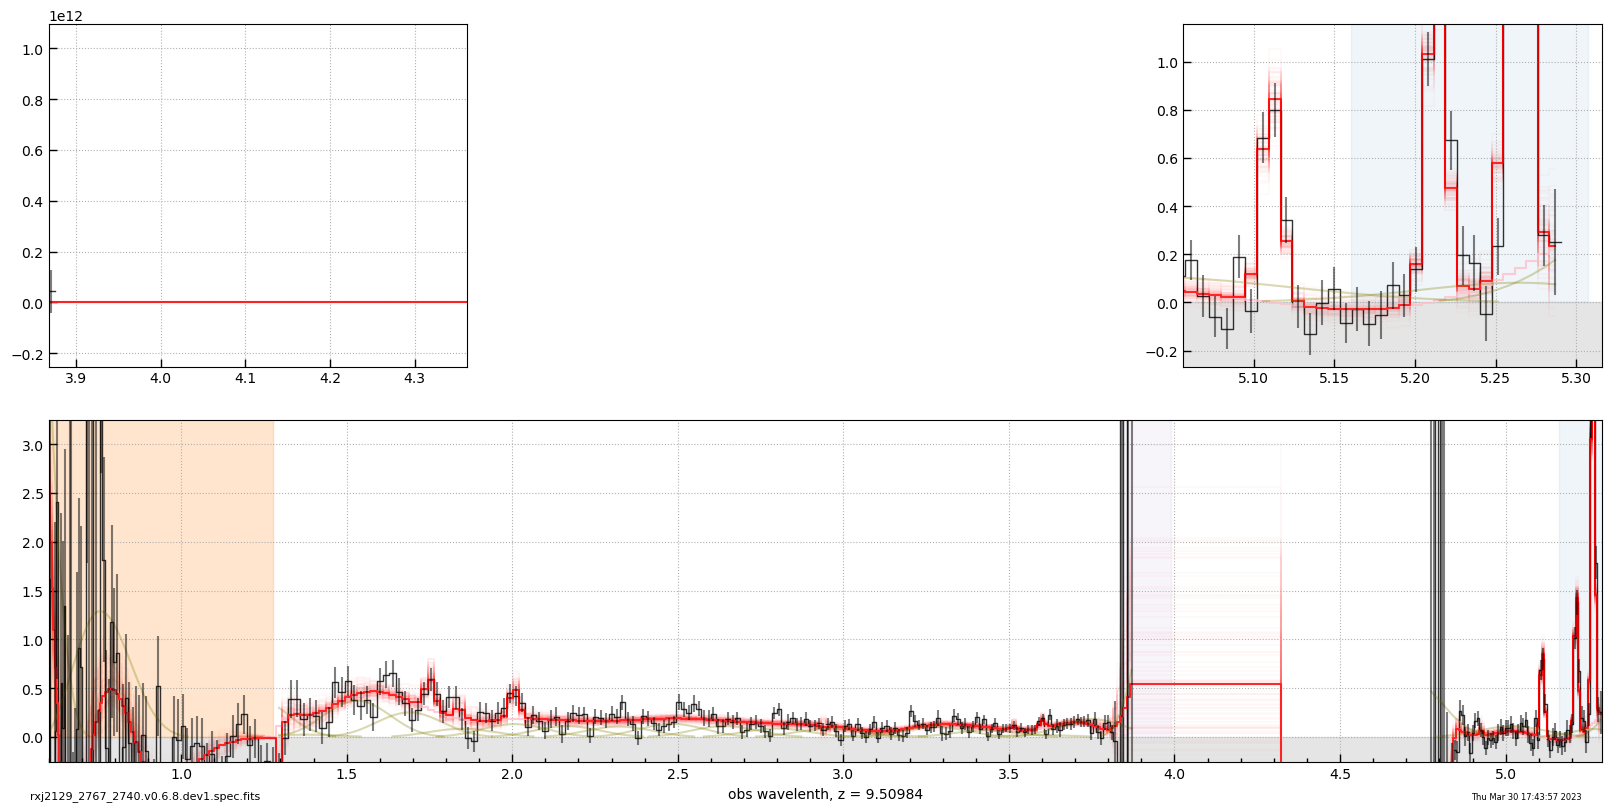

In [42]:
# Rescale uncertainties by a polynomial 
spectrum.SCALE_UNCERTAINTY = 1.0

fig, sp_scale, data = spectrum.plot_spectrum(file=spec_file, 
                           z=data['z'],
                          eazy_templates=None,
                          nspline=33, 
                           # plot_unit=u.microJansky,
                          scale_disp=1.3,
                          vel_width=50.,
                          is_prism=True, bkg=0,
                           scale_uncertainty_kwargs={'order':4, 'init':[1,3]},
                           use_full_dispersion=True,
                           Rline=2000,
                           ranges=[(3680, 4150), (4300, 4400), (4861-50, 5008+50)],
                         )

# fig.axes[3].semilogx()

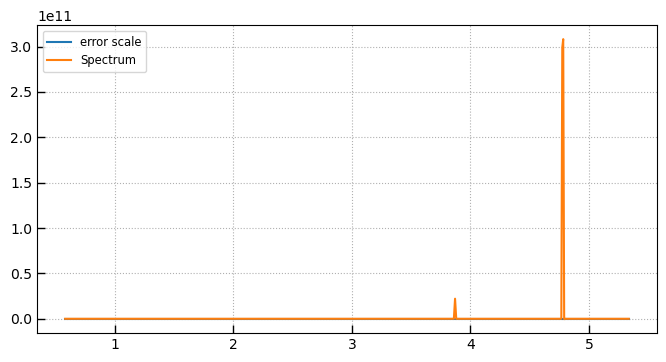

In [43]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(sp_scale['wave'], sp_scale['escale'], label='error scale')
ax.plot(sp_scale['wave'], sp_scale['flux'], label='Spectrum')
ax.legend()
ax.grid()

201it [00:00, 324.19it/s]
34it [00:00, 318.73it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# rxj2129_2767_2740.v0.6.8.dev1.spec.fits
# z = 9.50984
# Thu Mar 30 17:43:59 2023
             line Hb      135.4 ±     14.1
             line Hg        0.0 ±      0.0
             line Hd        0.0 ±      0.0
     line NeIII-3968        0.0 ±      0.0
      line OIII-4959      218.8 ±     16.2
      line OIII-5007      652.8 ±     27.2
      line OIII-4363        0.0 ±      0.0
            line OII        0.0 ±      0.0
      line HeII-4687        4.0 ±     10.5
     line NeIII-3867        0.0 ±      0.0
       line HeI-3889        0.0 ±      0.0
      line OIII-1663      120.3 ±     41.4
      line CIII-1908       90.0 ±     31.4
      line NIII-1750       -0.6 ±     38.8
            line Lya     -616.8 ±    165.9
           line MgII       -3.1 ±     14.7
       line NeV-3346        0.0 ±      8.9
      line NeVI-3426       13.8 ±      8.5


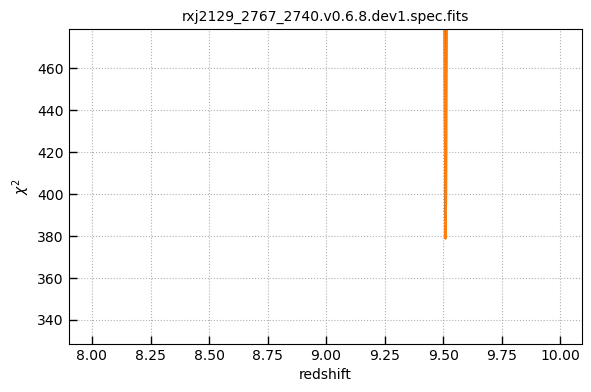

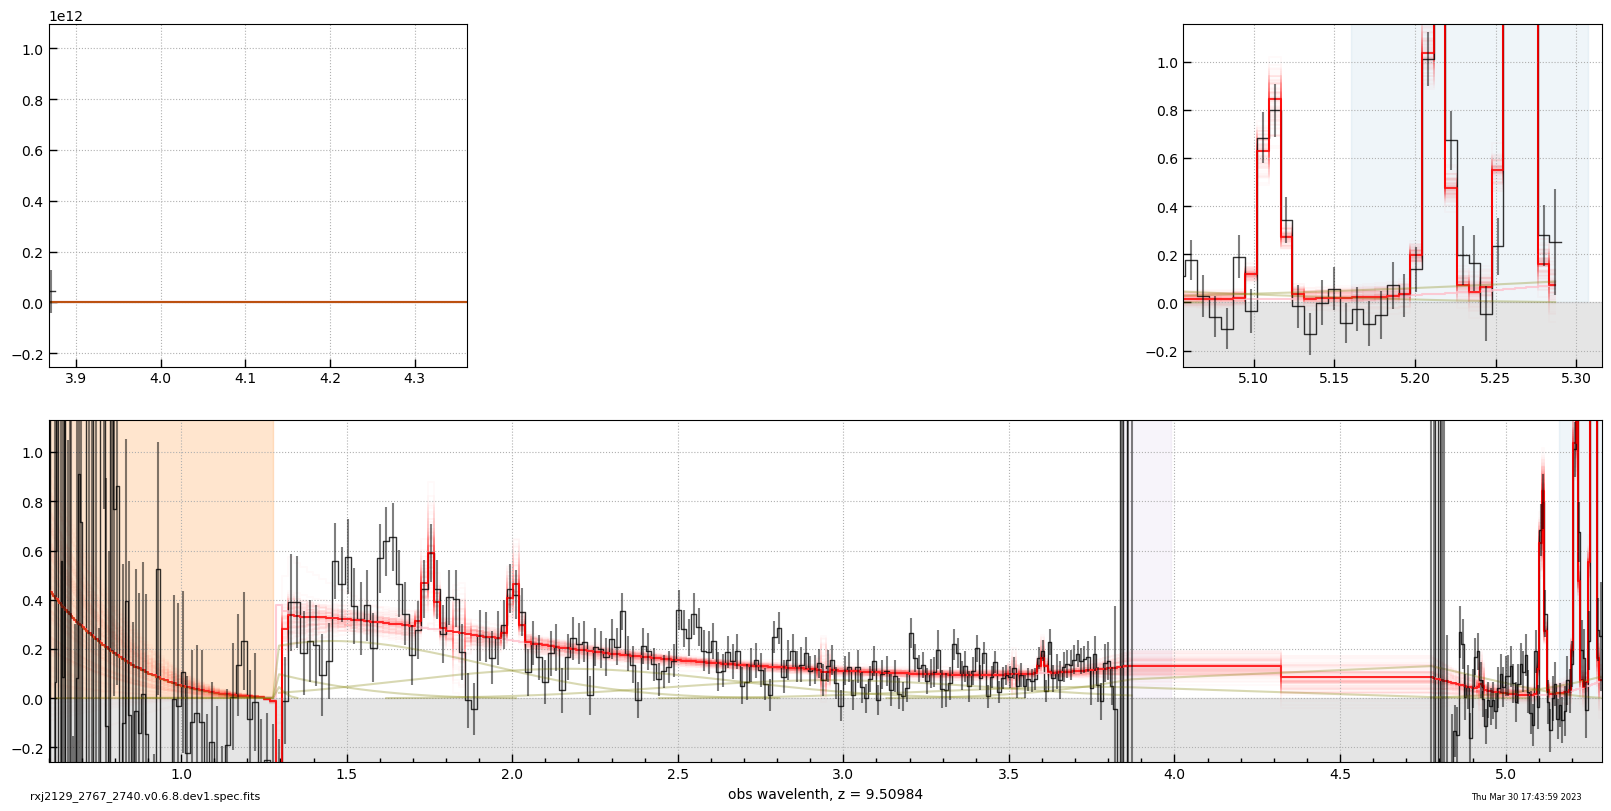

In [44]:
# Fit redshift again with scaled uncertainties

spectrum.FFTSMOOTH = False

fig, sp, data = spectrum.fit_redshift(file=spec_file,
                          z0=[8.,10], 
                          zstep=[0.001,0.0003],
                          eazy_templates=None,
                          nspline=9,
                          scale_disp=1.3,
                          vel_width=50.,
                          Rline=2000,
                          is_prism=True,
                          use_full_dispersion=False,
                          ranges=[(3680, 4150), (4300, 4400), (4861-50, 5008+50)],
                         )

In [45]:
# Stop the notebook if "Run All"
break

SyntaxError: 'break' outside loop (4272937315.py, line 2)

# Process all groups

In [ ]:
groups = pipeline.exposure_groups()
groups

for mode in groups:
    if ('02767' in mode): # & (not os.path.exists(f'{mode}.slits.yaml')):
        # Run the pipeline to define slits, etc., but don't do extractions yet.  
        pipe = pipeline.NirspecPipeline(mode=mode)
        pipe.full_pipeline(run_extractions=False, initialize_bkg=False)
    else:
        print(f'Skip {mode}')

In [ ]:
import glob
import yaml
import grizli.utils

files = glob.glob('*2767*slits.yaml')
files.sort()

all_targets = []
skip = []
for file in files:
    with open(file) as fp:
        slits = yaml.load(fp, Loader=yaml.Loader)
        for k in slits:
            all_targets.append(k)

un = grizli.utils.Unique(all_targets)
targets = un.values
print(len(targets))
#targets

In [ ]:
from importlib import reload
from msaexp import pipeline
reload(pipeline)
print(pipeline.__file__)


gratings = {}
for mode in groups:
    if os.path.exists(f'{mode}.slits.yaml') & ('02767' in mode):
        # Run the pipeline to define slits, etc., but don't do extractions yet.  
        obj = pipeline.NirspecPipeline(mode=mode)
        obj.full_pipeline(run_extractions=False, targets=targets)
        
        if obj.grating not in gratings:
            gratings[obj.grating] = []
        
        gratings[obj.grating].append(obj)